# Guía de uso

1.  **Cargar los datos:**
    *   Asegúrate de que los archivos de datos de temperatura y humedad estén en formato Excel (.xlsx).
    *   Los archivos deben contener columnas con las fechas, horas y los datos de cada sensor. Las filas deben iniciar en la celda A1 del Libro de Excel y cada Hoja tiene que tener las siguientes columnas:
      en la celda A1⟶'Fecha', en la celda B1⟶'Hora', las celdas consecutivas en la fila 1 tienen que ser los nombres/números de serie (sin formato especifico) de los sensores a analizar.
    * 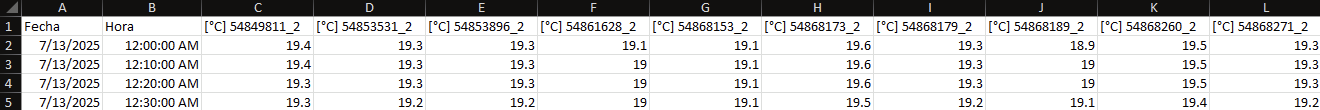
    *   En la sección "Ingreso de datos"  hay que asegurarse de que las variables `nombre_archivo_temperatura`,`nombre_archivo_humedad`,`nombre_hoja_temperatura` y `nombre_hoja_humedad` sean exactamente iguales a los nombres de los archivos y de las hojas del excel en las que se encuentran los datos a analizar.
    * 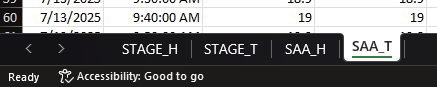
    *   También se puede especificar un rango de fechas y horas para filtrar los datos si no se quiere analizar toda la información disponible. Editando las variables `fecha_hora_inicio_temperatura`, `fecha_hora_fin_temperatura`, `fecha_hora_inicio_humedad`, y `fecha_hora_fin_humedad` con el formato indicado ("AAAA-MM-DD HH:MM:SS"). En caso de dejar las fechas de inicio y fin vacías (""), se analizarán todos los datos disponibles en el archivo.

2.  **Seleccionar sensores (Opcional):**
    *   En la sección "Selección de grupos", verás una lista desplegable. Elige si quieres trabajar con datos de temperatura, humedad o ambos.
    *   Si eliges agrupar, aparecerán listas para seleccionar los sensores específicos que te interesan (deacuerdo a la seleccion anterior). Haz click en los sensores que deseas incluir. Para seleccionar varios sensores no seguidos, mantén presionada la tecla `Ctrl` (o `Cmd` en Mac) mientras haces clic.
    *   Después de seleccionar los sensores, haz clic en el botón "Confirmar Selección" para cada tipo de datos (temperatura y/o humedad).

3.  **Ejecutar el cuaderno:**
    *   Una vez que hayas configurado los nombres de archivo, hojas, rango de fechas (si aplica), puedes ejecutar todas las celdas del cuaderno utilizando el botón `▹Run all` en la parte superior derecha del cuaderno.
    * En caso de hacer una selección por grupos, se tendrá que correr manualmente cada celda en orden de aparición de las secciones "Librerias", "Ingreso de datos" y "Selección de grupos", posteriormente se puede correr el resto del cuaderno utilizando `Ctrl`+`F10` (o `Command`+`Shift`+`Enter` en Mac), alternativamente se puede la opcion 'Run cell and below' del menú 'Runtime' en el archivo.
    * 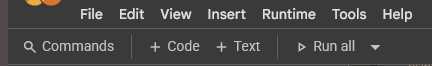
4.  **Revisar los resultados:**
    *   Desplázate hacia abajo o utiliza la tabla de contenidos para ver los boxplots, los gráficos de tendencias y las tablas de valores extremos esten generadas correectamente apartir de la seleccion de archivos, hojas, fechas y grupos seleccionados.

##Librerias

In [324]:
import pandas as pd
from google.colab import files
import io
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import ipywidgets as widgets
from IPython.display import display
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import re

#Ingreso de datos

In [325]:
nombre_archivo_temperatura = 'datos crudos int 7_043416.xlsx'
nombre_hoja_temperatura = '15 a 18 tem'
nombre_archivo_humedad = 'datos crudos int 7_043416.xlsx'
nombre_hoja_humedad = '15 a 18 hum'
#formato de fecha y hora en aaaa-mm-dd hh:mm:ss
fecha_hora_inicio_temperatura = ""
fecha_hora_fin_temperatura = ""
fecha_hora_inicio_humedad = ""
fecha_hora_fin_humedad = ""

In [326]:
df_humidity = pd.read_excel(nombre_archivo_humedad, sheet_name=nombre_hoja_humedad)
df_temp = pd.read_excel(nombre_archivo_temperatura, sheet_name= nombre_hoja_temperatura)
sensor_columns_temp = df_temp.columns[2:]
sensor_columns_humidity = df_humidity.columns[2:]
df_temp['Timestamp'] = pd.to_datetime(df_temp['Fecha'].astype(str) + ' ' + df_temp['Hora'].astype(str), format='mixed', dayfirst=True)
df_humidity['Timestamp'] = pd.to_datetime(df_humidity['Fecha'].astype(str) + ' ' + df_humidity['Hora'].astype(str), format='mixed', dayfirst=True)

##Limpieza de Datos

In [327]:
def dedup_por_timestamp(df, ts_col="Timestamp", keep="first"):
    df = df.copy()
    df[ts_col] = pd.to_datetime(df[ts_col], errors="coerce")
    df = df.sort_values(ts_col)
    df = df.drop_duplicates(subset=[ts_col], keep=keep)
    return df.reset_index(drop=True)

# aplica a tus tablas
df_temp     = dedup_por_timestamp(df_temp,     "Timestamp", keep="first")  # o "last"
df_humidity = dedup_por_timestamp(df_humidity, "Timestamp", keep="first")  # o "last"


#Selección de grupos

In [328]:
grouping_choice_dropdown = widgets.Dropdown(
    options=['None', 'Temperature', 'Humidity', 'Both'],
    description='Select data type for grouping:',)
display(grouping_choice_dropdown)

Dropdown(description='Select data type for grouping:', options=('None', 'Temperature', 'Humidity', 'Both'), va…

In [329]:
if grouping_choice_dropdown.value in ['Temperature', 'Both']:
    temp_sensor_search = widgets.Text(
        description='Search temperature sensor:',
        placeholder='Enter sensor name or part of it')
    temp_sensor_selector = widgets.SelectMultiple(
        options=sensor_columns_temp.tolist(),
        description='Select temperature sensors:',
        disabled=False,
        layout=widgets.Layout(width='50%'))
    add_temp_sensor_button = widgets.Button(description="Agregar a Selección")
    confirm_temp_selection_button = widgets.Button(description="Confirmar Selección")
    output_temp = widgets.Output()
    selected_temp_sensors_temp_list = []
    def update_temp_options(change):
        search_term = change['new'].lower()
        filtered_options = [sensor for sensor in sensor_columns_temp.tolist() if search_term in sensor.lower()]
        temp_sensor_selector.options = filtered_options
    def on_add_temp_button_clicked(b):
        with output_temp:
            for sensor in temp_sensor_selector.value:
                if sensor not in selected_temp_sensors_temp_list:
                    selected_temp_sensors_temp_list.append(sensor)
            print(f"Sensores de temperatura añadidos a la selección preliminar: {selected_temp_sensors_temp_list}")
    def on_temp_button_clicked(b):
        with output_temp:
            global selected_temp_sensors
            selected_temp_sensors = list(selected_temp_sensors_temp_list)
            selected_temp_sensors_temp_list.clear()
            print(f"Selected temperature sensors: {selected_temp_sensors}")
    temp_sensor_search.observe(update_temp_options, names='value')
    add_temp_sensor_button.on_click(on_add_temp_button_clicked)
    confirm_temp_selection_button.on_click(on_temp_button_clicked)
    display(temp_sensor_search, temp_sensor_selector)
    display(add_temp_sensor_button, confirm_temp_selection_button, output_temp)

In [330]:
if grouping_choice_dropdown.value in ['Temperature', 'Both'] and 'selected_temp_sensors' in globals() and selected_temp_sensors:
    df_temp = df_temp[['Fecha', 'Hora', 'Timestamp'] + selected_temp_sensors].copy()
    sensor_columns_temp = [col for col in df_temp.columns if col not in ['Fecha', 'Hora', 'Timestamp']]
    print("df_temp filtered based on selection.")
elif grouping_choice_dropdown.value in ['Temperature', 'Both'] and 'selected_temp_sensors' in globals() and not selected_temp_sensors:
    print("No temperature sensors selected. Keeping all temperature sensors.")
    sensor_columns_temp = [col for col in df_temp.columns if col not in ['Fecha', 'Hora', 'Timestamp']]
else:
    sensor_columns_temp = [col for col in df_temp.columns if col not in ['Fecha', 'Hora', 'Timestamp']]

In [331]:
if grouping_choice_dropdown.value in ['Humidity', 'Both']:
    humidity_sensor_search = widgets.Text(
        description='Search humidity sensor:',
        placeholder='Enter sensor name or part of it')
    humidity_sensor_selector = widgets.SelectMultiple(
        options=sensor_columns_humidity.tolist(),
        description='Select humidity sensors:',
        disabled=False)
    add_humidity_sensor_button = widgets.Button(description="Agregar a Selección")
    confirm_humidity_selection_button = widgets.Button(description="Confirmar Selección")
    output_humidity = widgets.Output()
    selected_humidity_sensors_temp_list = []
    def update_humidity_options(change):
        search_term = change['new'].lower()
        filtered_options = [sensor for sensor in sensor_columns_humidity.tolist() if search_term in sensor.lower()]
        humidity_sensor_selector.options = filtered_options
    def on_add_humidity_button_clicked(b):
        with output_humidity:
            for sensor in humidity_sensor_selector.value:
                if sensor not in selected_humidity_sensors_temp_list:
                    selected_humidity_sensors_temp_list.append(sensor)
            print(f"Sensores de humedad añadidos a la selección preliminar: {selected_humidity_sensors_temp_list}")
    def on_humidity_button_clicked(b):
        with output_humidity:
            global selected_humidity_sensors
            selected_humidity_sensors = list(selected_humidity_sensors_temp_list)
            selected_humidity_sensors_temp_list.clear()
            print(f"Selected humidity sensors: {selected_humidity_sensors}")
    humidity_sensor_search.observe(update_humidity_options, names='value')
    add_humidity_sensor_button.on_click(on_add_humidity_button_clicked)
    confirm_humidity_selection_button.on_click(on_humidity_button_clicked)
    display(humidity_sensor_search, humidity_sensor_selector)
    display(add_humidity_sensor_button, confirm_humidity_selection_button, output_humidity)

In [332]:
if grouping_choice_dropdown.value in ['Humidity', 'Both'] and 'selected_humidity_sensors' in globals() and selected_humidity_sensors:
    df_humidity = df_humidity[['Fecha', 'Hora', 'Timestamp'] + selected_humidity_sensors].copy()
    sensor_columns_humidity = [col for col in df_humidity.columns if col not in ['Fecha', 'Hora', 'Timestamp']]
    print("df_humidity filtered based on selection.")
elif grouping_choice_dropdown.value in ['Humidity', 'Both'] and 'selected_humidity_sensors' in globals() and not selected_humidity_sensors:
    print("No humidity sensors selected. Keeping all humidity sensors.")
    sensor_columns_humidity = [col for col in df_humidity.columns if col not in ['Fecha', 'Hora', 'Timestamp']]
else:
    sensor_columns_humidity = [col for col in df_humidity.columns if col not in ['Fecha', 'Hora', 'Timestamp']]

Para no correr manualmente todas las celdas siguientes, puede utilizar `Ctrl`+`F10` (o `Command`+`Shift`+`Enter` en Mac), alternativamente se puede la opcion 'Run cell and below' del menú 'Runtime' en el archivo.

##Procesamiento y análisis Temperatura

In [333]:
uploaded_temp =  pd.read_excel(nombre_archivo_temperatura, sheet_name=nombre_hoja_temperatura)
uploaded_humidity =  pd.read_excel(nombre_archivo_humedad, sheet_name=nombre_hoja_humedad)
temp_start_timestamp_str = fecha_hora_inicio_temperatura
temp_end_timestamp_str = fecha_hora_fin_temperatura
humidity_start_timestamp_str = fecha_hora_inicio_humedad
humidity_end_timestamp_str = fecha_hora_fin_humedad
temp_file_name = list(uploaded_temp.keys())[0]
for col in sensor_columns_temp:
    df_temp[col] = pd.to_numeric(df_temp[col], errors='coerce')
    df_temp[col] = df_temp[col].fillna(df_temp[col].mean())
sensor_stats_temp = {}
for col in sensor_columns_temp:
    max_value = df_temp[col].max()
    min_value = df_temp[col].min()
    mean_value = df_temp[col].mean()
    max_freq = df_temp[col].value_counts().get(max_value, 0)
    min_freq = df_temp[col].value_counts().get(min_value, 0)
    sensor_stats_temp[col] = {
        'max_value': max_value,
        'max_frequency': max_freq,
        'min_value': min_value,
        'min_frequency': min_freq,
        'average_value': mean_value}
first_sensor_temp = list(sensor_stats_temp.keys())[0]
overall_max_value_temp = sensor_stats_temp[first_sensor_temp]['max_value']
overall_max_sensor_temp = first_sensor_temp
overall_min_value_temp = sensor_stats_temp[first_sensor_temp]['min_value']
overall_min_sensor_temp = first_sensor_temp
min_average_value_temp = sensor_stats_temp[first_sensor_temp]['average_value']
min_average_sensor_temp = first_sensor_temp
max_average_value_temp = sensor_stats_temp[first_sensor_temp]['average_value']
max_average_sensor_temp = first_sensor_temp
for sensor, stats in sensor_stats_temp.items():
    if stats['max_value'] > overall_max_value_temp:
        overall_max_value_temp = stats['max_value']
        overall_max_sensor_temp = sensor
    if stats['min_value'] < overall_min_value_temp:
        overall_min_value_temp = stats['min_value']
        overall_min_sensor_temp = sensor
    if stats['average_value'] < min_average_value_temp:
        min_average_value_temp = stats['average_value']
        min_average_sensor_temp = sensor
    if stats['average_value'] > max_average_value_temp:
        max_average_value_temp = stats['average_value']
        max_average_sensor_temp = sensor

##Procesamiento y análisis Humedad

In [334]:
humidity_file_name = list(uploaded_humidity.keys())[0]
for col in sensor_columns_humidity:
    df_humidity[col] = pd.to_numeric(df_humidity[col], errors='coerce')
    df_humidity[col] = df_humidity[col].fillna(df_humidity[col].mean())
sensor_stats_humidity = {}
for col in sensor_columns_humidity:
    max_value = df_humidity[col].max()
    min_value = df_humidity[col].min()
    mean_value = df_humidity[col].mean()
    max_freq = df_humidity[col].value_counts().get(max_value, 0)
    min_freq = df_humidity[col].value_counts().get(min_value, 0)
    sensor_stats_humidity[col] = {
        'max_value': max_value,
        'max_frequency': max_freq,
        'min_value': min_value,
        'min_frequency': min_freq,
        'average_value': mean_value}
first_sensor_humidity = list(sensor_stats_humidity.keys())[0]
overall_max_value_humidity = sensor_stats_humidity[first_sensor_humidity]['max_value']
overall_max_sensor_humidity = first_sensor_humidity
overall_min_value_humidity = sensor_stats_humidity[first_sensor_humidity]['min_value']
overall_min_sensor_humidity = first_sensor_humidity
min_average_value_humidity = sensor_stats_humidity[first_sensor_humidity]['average_value']
min_average_sensor_humidity = first_sensor_humidity
max_average_value_humidity = sensor_stats_humidity[first_sensor_humidity]['average_value']
max_average_sensor_humidity = first_sensor_humidity
for sensor, stats in sensor_stats_humidity.items():
    if stats['max_value'] > overall_max_value_humidity:
        overall_max_value_humidity = stats['max_value']
        overall_max_sensor_humidity = sensor
    if stats['min_value'] < overall_min_value_humidity:
        overall_min_value_humidity = stats['min_value']
        overall_min_sensor_humidity = sensor
    if stats['average_value'] < min_average_value_humidity:
        min_average_value_humidity = stats['average_value']
        min_average_sensor_humidity = sensor
    if stats['average_value'] > max_average_value_humidity:
        max_average_value_humidity = stats['average_value']
        max_average_sensor_humidity = sensor

#Filtrado de datos por fecha y hora seleecionada

In [335]:
temp_start_datetime = pd.to_datetime(temp_start_timestamp_str, errors='coerce')
temp_end_datetime = pd.to_datetime(temp_end_timestamp_str, errors='coerce')
humidity_start_datetime = pd.to_datetime(humidity_start_timestamp_str, errors='coerce')
humidity_end_datetime = pd.to_datetime(humidity_end_timestamp_str, errors='coerce')
df_temp['Timestamp'] = pd.to_datetime(df_temp['Timestamp'])
df_humidity['Timestamp'] = pd.to_datetime(df_humidity['Timestamp'])
if pd.notnull(temp_start_datetime) and pd.notnull(temp_end_datetime):
    df_temp_filtered = df_temp[(df_temp['Timestamp'] >= temp_start_datetime) & (df_temp['Timestamp'] <= temp_end_datetime)].copy()
    print(f"Datos de temperatura filtrados desde {temp_start_datetime} hasta {temp_end_datetime}")
else:
    df_temp_filtered = df_temp.copy()
    print("No se especificó un rango de fecha y hora para temperatura. Mostrando todos los datos.")
if pd.notnull(humidity_start_datetime) and pd.notnull(humidity_end_datetime):
    df_humidity_filtered = df_humidity[(df_humidity['Timestamp'] >= humidity_start_datetime) & (df_humidity['Timestamp'] <= humidity_end_datetime)].copy()
    print(f"Datos de humedad filtrados desde {humidity_start_datetime} hasta {humidity_end_datetime}")
else:
    df_humidity_filtered = df_humidity.copy()
    print("No se especificó un rango de fecha y hora para humedad. Mostrando todos los datos.")

No se especificó un rango de fecha y hora para temperatura. Mostrando todos los datos.
No se especificó un rango de fecha y hora para humedad. Mostrando todos los datos.


##Análisis de valores extremos e intervalos de continuidad

In [336]:
extreme_values_temp_filtered_df = pd.DataFrame(columns=['Sensor', 'Fecha', 'Hora', 'Valor', 'Tipo'])
for index, row in df_temp_filtered.iterrows():
    fecha = row['Fecha']
    hora = row['Hora']
    for sensor in sensor_columns_temp:
        value = row[sensor]
        if value == overall_max_value_temp:
            extreme_values_temp_filtered_df = pd.concat([extreme_values_temp_filtered_df, pd.DataFrame([{
                'Sensor': sensor,
                'Fecha': fecha,
                'Hora': hora,
                'Valor': value,
                'Tipo': 'Máximo General'
            }])], ignore_index=True)
        if value == overall_min_value_temp:
            extreme_values_temp_filtered_df = pd.concat([extreme_values_temp_filtered_df, pd.DataFrame([{
                'Sensor': sensor,
                'Fecha': fecha,
                'Hora': hora,
                'Valor': value,
                'Tipo': 'Mínimo General'
            }])], ignore_index=True)
extreme_values_humidity_filtered_df = pd.DataFrame(columns=['Sensor', 'Fecha', 'Hora', 'Valor', 'Tipo'])
for index, row in df_humidity_filtered.iterrows():
    fecha = row['Fecha']
    hora = row['Hora']
    for sensor in sensor_columns_humidity:
        value = row[sensor]
        if value == overall_max_value_humidity:
            extreme_values_humidity_filtered_df = pd.concat([extreme_values_humidity_filtered_df, pd.DataFrame([{
                'Sensor': sensor,
                'Fecha': fecha,
                'Hora': hora,
                'Valor': value,
                'Tipo': 'Máximo General'
            }])], ignore_index=True)
        if value == overall_min_value_humidity:
            extreme_values_humidity_filtered_df = pd.concat([extreme_values_humidity_filtered_df, pd.DataFrame([{
                'Sensor': sensor,
                'Fecha': fecha,
                'Hora': hora,
                'Valor': value,
                'Tipo': 'Mínimo General'
            }])], ignore_index=True)
def find_contiguous_intervals(timestamps, delta=pd.Timedelta(minutes=1)):
    intervals = []
    if timestamps.empty:
        return intervals
    current_start = timestamps.iloc[0]
    current_end = timestamps.iloc[0]
    for ts in timestamps[1:]:
        if ts - current_end <= delta:
            current_end = ts
        else:
            intervals.append((current_start, current_end))
            current_start = ts
            current_end = ts
    intervals.append((current_start, current_end))
    return intervals
all_grouped_extreme_values_temp = []
unique_sensors_temp = extreme_values_temp_filtered_df['Sensor'].unique().tolist()
for sensor in unique_sensors_temp:
    for extreme_type in ['Máximo General', 'Mínimo General']:
        sensor_extreme_df_temp = extreme_values_temp_filtered_df[
            (extreme_values_temp_filtered_df['Sensor'] == sensor) &
            (extreme_values_temp_filtered_df['Tipo'] == extreme_type)].copy()
        if not sensor_extreme_df_temp.empty:
            sensor_extreme_df_temp['Fecha'] = pd.to_datetime(sensor_extreme_df_temp['Fecha'])
            sensor_extreme_df_temp['Timestamp_dt'] = pd.to_datetime(sensor_extreme_df_temp['Fecha'].dt.strftime('%Y-%m-%d') + ' ' + sensor_extreme_df_temp['Hora'].astype(str), format='mixed', dayfirst=True)
            sensor_extreme_df_temp = sensor_extreme_df_temp.sort_values(by='Timestamp_dt').reset_index(drop=True)
            sensor_extreme_df_temp['Time_diff'] = sensor_extreme_df_temp['Timestamp_dt'].diff().fillna(pd.Timedelta(seconds=0))
            sensor_extreme_df_temp['Consecutive_group'] = (sensor_extreme_df_temp['Time_diff'] > pd.Timedelta(minutes=10)).cumsum()
            grouped_data_temp = []
            for name, group in sensor_extreme_df_temp.groupby('Consecutive_group'):
                start_time = group['Timestamp_dt'].iloc[0].time()
                end_time = group['Timestamp_dt'].iloc[-1].time()
                frequency = len(group)
                if start_time == end_time:
                    hora_range = start_time.strftime('%H:%M:%S')
                else:
                    hora_range = f"{start_time.strftime('%H:%M:%S')}-{end_time.strftime('%H:%M:%S')}"
                grouped_data_temp.append({
                    'Sensor': sensor,
                    'Fecha': group['Fecha'].iloc[0].date(),
                    'Hora (Rango)': hora_range,
                    'Valor Registrado': group['Valor'].iloc[0],
                    'Frecuencia': frequency,
                    'Tipo': extreme_type})
            all_grouped_extreme_values_temp.extend(grouped_data_temp)
all_grouped_extreme_values_humidity = []
unique_sensors_humidity = extreme_values_humidity_filtered_df['Sensor'].unique().tolist()
for sensor in unique_sensors_humidity:
    for extreme_type in ['Máximo General', 'Mínimo General']:
        sensor_extreme_df_humidity = extreme_values_humidity_filtered_df[
            (extreme_values_humidity_filtered_df['Sensor'] == sensor) &
            (extreme_values_humidity_filtered_df['Tipo'] == extreme_type)].copy()
        if not sensor_extreme_df_humidity.empty:
            sensor_extreme_df_humidity['Fecha'] = pd.to_datetime(sensor_extreme_df_humidity['Fecha'])
            sensor_extreme_df_humidity['Timestamp_dt'] = pd.to_datetime(sensor_extreme_df_humidity['Fecha'].dt.strftime('%Y-%m-%d') + ' ' + sensor_extreme_df_humidity['Hora'].astype(str), format='mixed', dayfirst=True)
            sensor_extreme_df_humidity = sensor_extreme_df_humidity.sort_values(by='Timestamp_dt').reset_index(drop=True)
            sensor_extreme_df_humidity['Time_diff'] = sensor_extreme_df_humidity['Timestamp_dt'].diff().fillna(pd.Timedelta(seconds=0))
            sensor_extreme_df_humidity['Consecutive_group'] = (sensor_extreme_df_humidity['Time_diff'] > pd.Timedelta(minutes=10)).cumsum()
            grouped_data_humidity = []
            for name, group in sensor_extreme_df_humidity.groupby('Consecutive_group'):
                start_time = group['Timestamp_dt'].iloc[0].time()
                end_time = group['Timestamp_dt'].iloc[-1].time()
                frequency = len(group)
                if start_time == end_time:
                    hora_range = start_time.strftime('%H:%M:%S')
                else:
                    hora_range = f"{start_time.strftime('%H:%M:%S')}-{end_time.strftime('%H:%M:%S')}"
                grouped_data_humidity.append({
                    'Sensor': sensor,
                    'Fecha': group['Fecha'].iloc[0].date(),
                    'Hora (Rango)': hora_range,
                    'Valor Registrado': group['Valor'].iloc[0],
                    'Frecuencia': frequency,
                    'Tipo': extreme_type})
            all_grouped_extreme_values_humidity.extend(grouped_data_humidity)
df_grouped_extreme_temp = pd.DataFrame(all_grouped_extreme_values_temp)
df_grouped_extreme_humidity = pd.DataFrame(all_grouped_extreme_values_humidity)

#Boxplots

##Temperatura

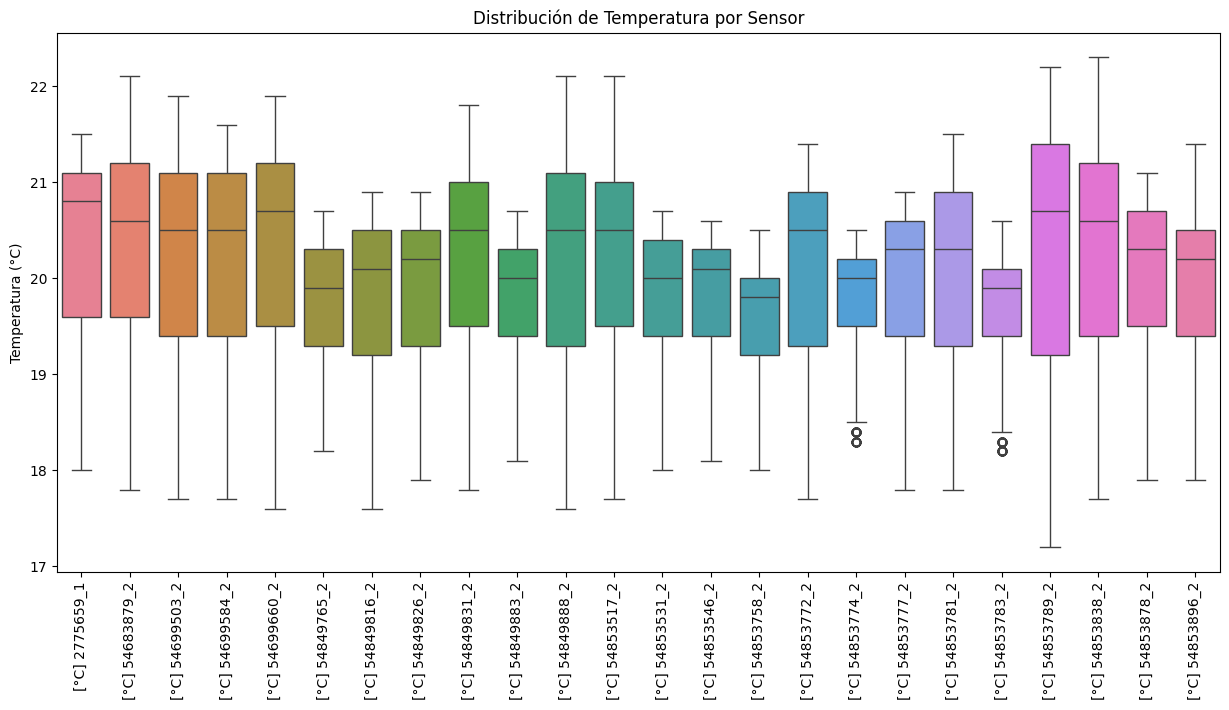

In [337]:
plt.figure(figsize=(15, 7))
sns.boxplot(data=df_temp_filtered[sensor_columns_temp])
plt.title('Distribución de Temperatura por Sensor')
plt.ylabel('Temperatura (°C)')
plt.xticks(rotation=90)
plt.show()

##Humedad

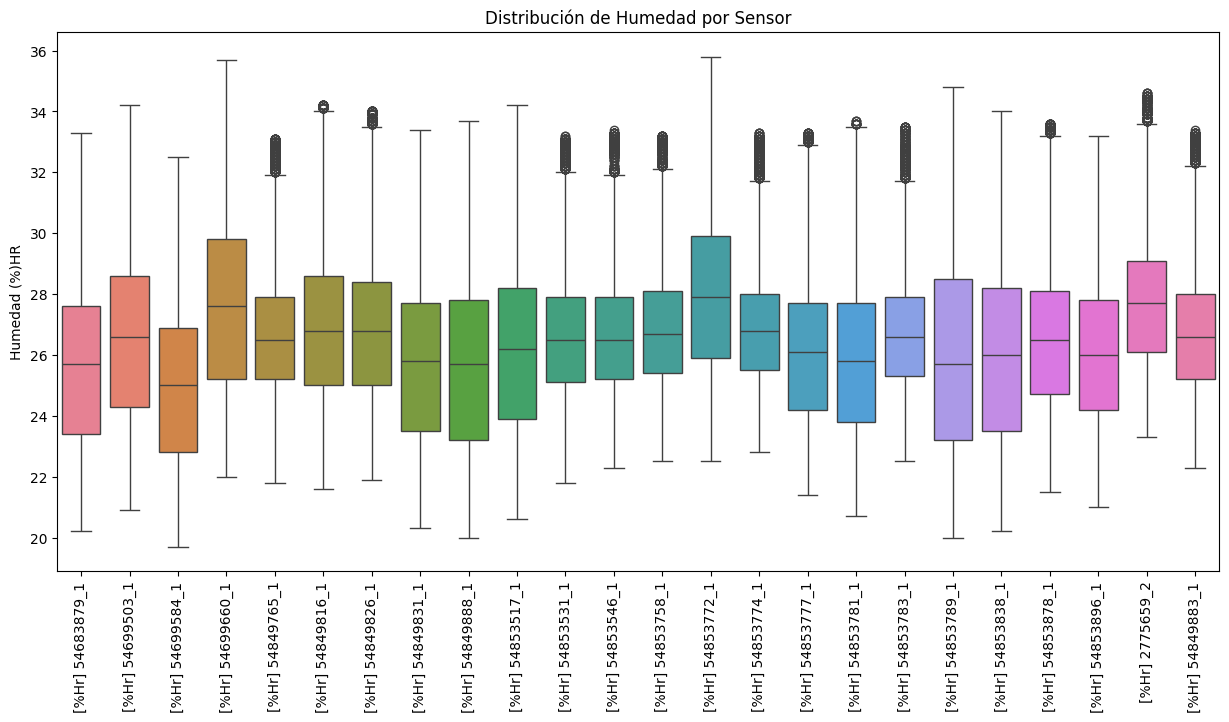

In [338]:
plt.figure(figsize=(15, 7))
sns.boxplot(data=df_humidity_filtered[sensor_columns_humidity])
plt.title('Distribución de Humedad por Sensor')
plt.ylabel('Humedad (%)HR')
plt.xticks(rotation=90)
plt.show()

#Tendencias todos los sensores

##Temperatura

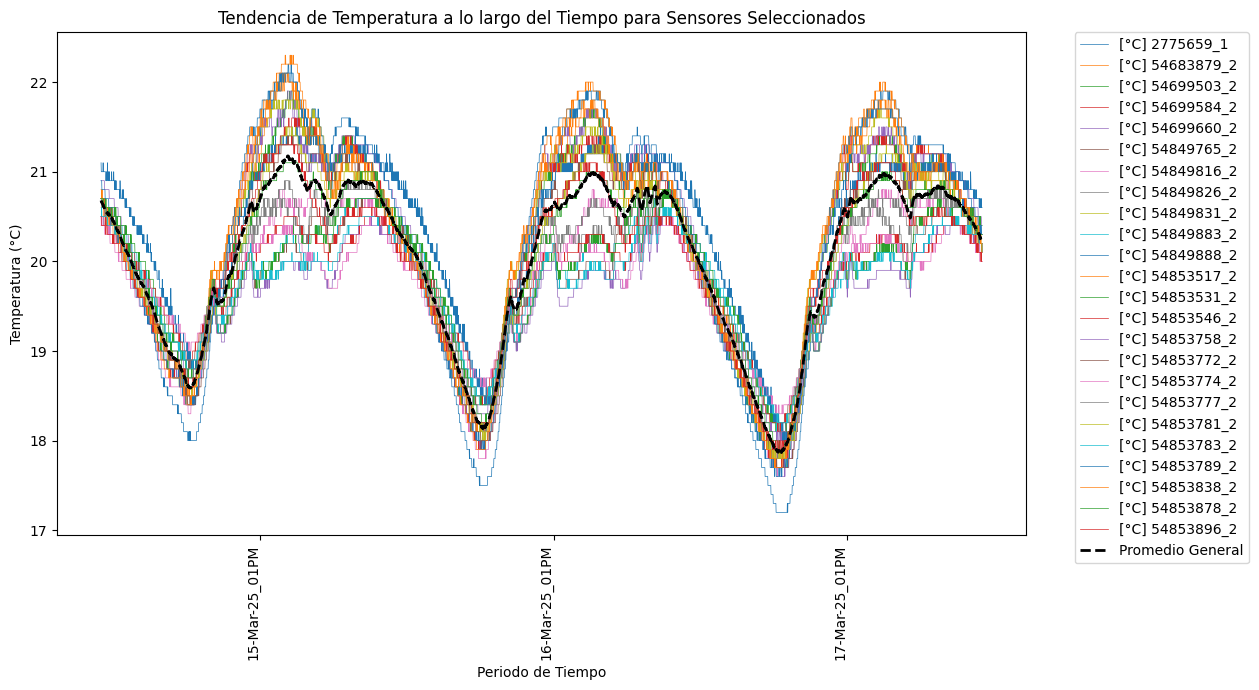

In [339]:
overall_average_temp_filtered = df_temp_filtered[sensor_columns_temp].mean(axis=1)
plt.figure(figsize=(15, 7))
plt.subplots_adjust(right=0.85)
for sensor in sensor_columns_temp:
    plt.plot(df_temp_filtered['Timestamp'], df_temp_filtered[sensor], label=sensor, linewidth=0.5)
plt.plot(df_temp_filtered['Timestamp'], overall_average_temp_filtered, label='Promedio General', linestyle='--', color='black', linewidth=2)
plt.title('Tendencia de Temperatura a lo largo del Tiempo para Sensores Seleccionados')
plt.xlabel('Periodo de Tiempo')
plt.ylabel('Temperatura (°C)')
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b-%y_%I%p'))
ax.xaxis.set_major_locator(mdates.HourLocator(interval=24))
plt.xticks(rotation=90, ha='right')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

##Humedad

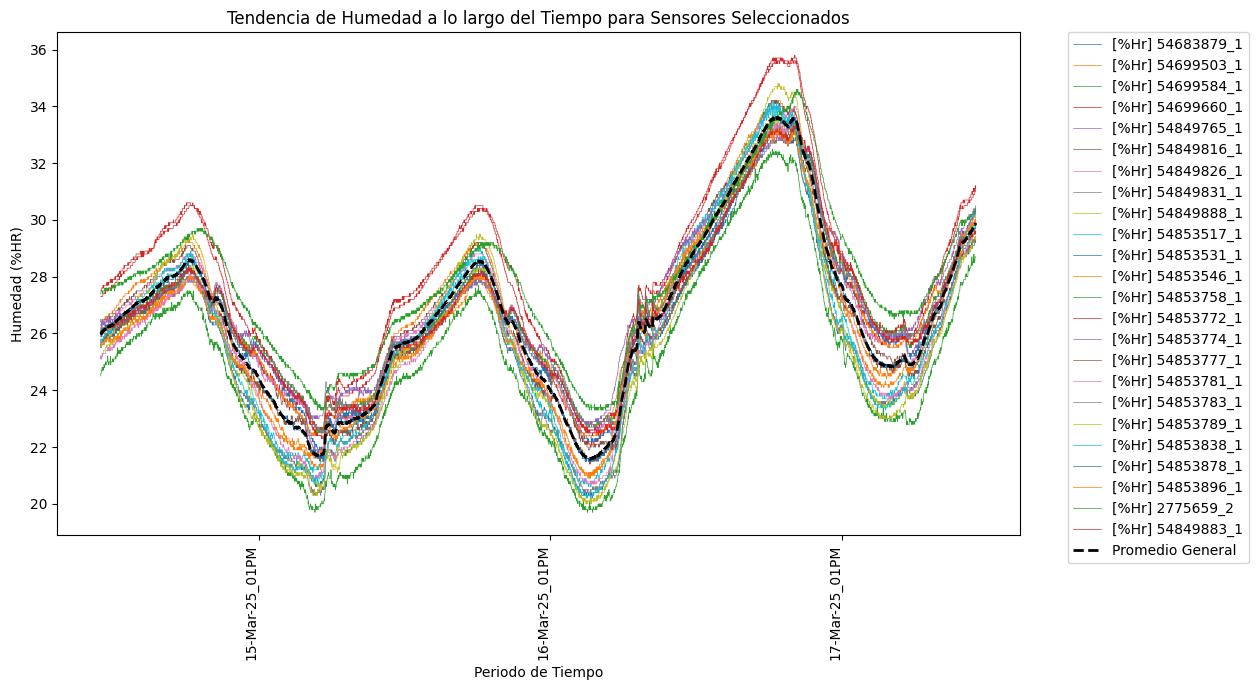

In [340]:
overall_average_humidity_filtered = df_humidity_filtered[sensor_columns_humidity].mean(axis=1)
plt.figure(figsize=(15, 7))
plt.subplots_adjust(right=0.85)
for sensor in sensor_columns_humidity:
    plt.plot(df_humidity_filtered['Timestamp'], df_humidity_filtered[sensor], label=sensor, linewidth=0.5)
plt.plot(df_humidity_filtered['Timestamp'], overall_average_humidity_filtered, label='Promedio General', linestyle='--', color='black', linewidth=2)
plt.title('Tendencia de Humedad a lo largo del Tiempo para Sensores Seleccionados')
plt.xlabel('Periodo de Tiempo')
plt.ylabel('Humedad (%HR)')
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b-%y_%I%p'))
ax.xaxis.set_major_locator(mdates.HourLocator(interval=24))
plt.xticks(rotation=90, ha='right')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

#Tendencias sensores destacados

##Temperatura

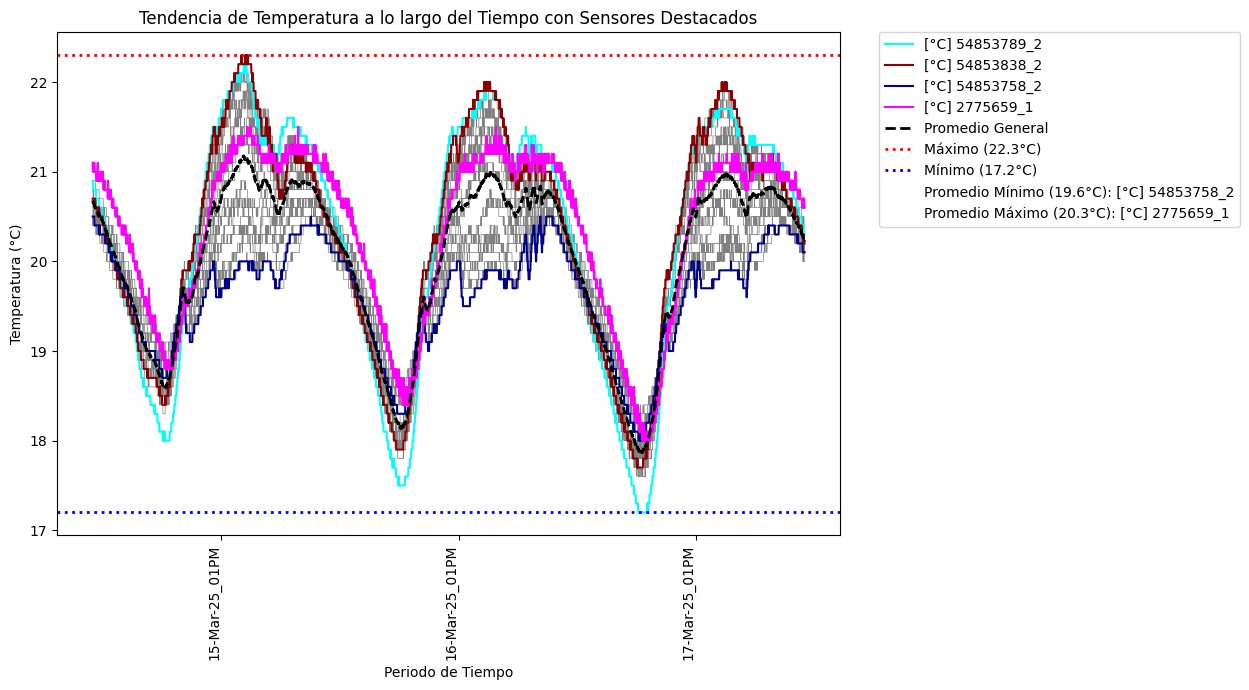

In [341]:
highlight_sensors_temp_filtered = {
    overall_min_sensor_temp: 'cyan',
    overall_max_sensor_temp: 'darkred',
    min_average_sensor_temp: 'darkblue',
    max_average_sensor_temp: 'magenta'}
plt.figure(figsize=(15, 7))
plt.subplots_adjust(right=0.85)
for sensor in sensor_columns_temp:
    plt.plot(df_temp_filtered['Timestamp'], df_temp_filtered[sensor], color='gray', linestyle='-', linewidth=0.5)
for sensor, color in highlight_sensors_temp_filtered.items():
    if sensor in sensor_columns_temp:
        plt.plot(df_temp_filtered['Timestamp'], df_temp_filtered[sensor], color=color, linestyle='-', linewidth=1.5, label=sensor)
plt.plot(df_temp_filtered['Timestamp'], overall_average_temp_filtered, label='Promedio General', linestyle='--', color='black', linewidth=2)
plt.axhline(y=overall_max_value_temp, color='red', linestyle=':', linewidth=2, label=f'Máximo ({overall_max_value_temp:.1f}°C)')
plt.axhline(y=overall_min_value_temp, color='blue', linestyle=':', linewidth=2, label=f'Mínimo ({overall_min_value_temp:.1f}°C)')
plt.title('Tendencia de Temperatura a lo largo del Tiempo con Sensores Destacados')
plt.xlabel('Periodo de Tiempo')
plt.ylabel('Temperatura (°C)')
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b-%y_%I%p'))
ax.xaxis.set_major_locator(mdates.HourLocator(interval=24))
plt.xticks(rotation=90, ha='right')
legend_handles, legend_labels = ax.get_legend_handles_labels()
filtered_handles = []
filtered_labels = []
desired_labels = list(highlight_sensors_temp_filtered.keys()) + ['Promedio General', f'Máximo ({overall_max_value_temp:.1f}°C)', f'Mínimo ({overall_min_value_temp:.1f}°C)']
for handle, label in zip(legend_handles, legend_labels):
    if label in desired_labels:
        filtered_handles.append(handle)
        filtered_labels.append(label)
additional_legend_info = [
    f"Promedio Mínimo ({min_average_value_temp:.1f}°C): {min_average_sensor_temp}",
    f"Promedio Máximo ({max_average_value_temp:.1f}°C): {max_average_sensor_temp}"]
dummy_handles = [plt.Line2D([0], [0], linestyle='none', label=info) for info in additional_legend_info]
all_handles = filtered_handles + dummy_handles
all_labels = filtered_labels + additional_legend_info
plt.legend(handles=all_handles, labels=all_labels, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

##Humedad

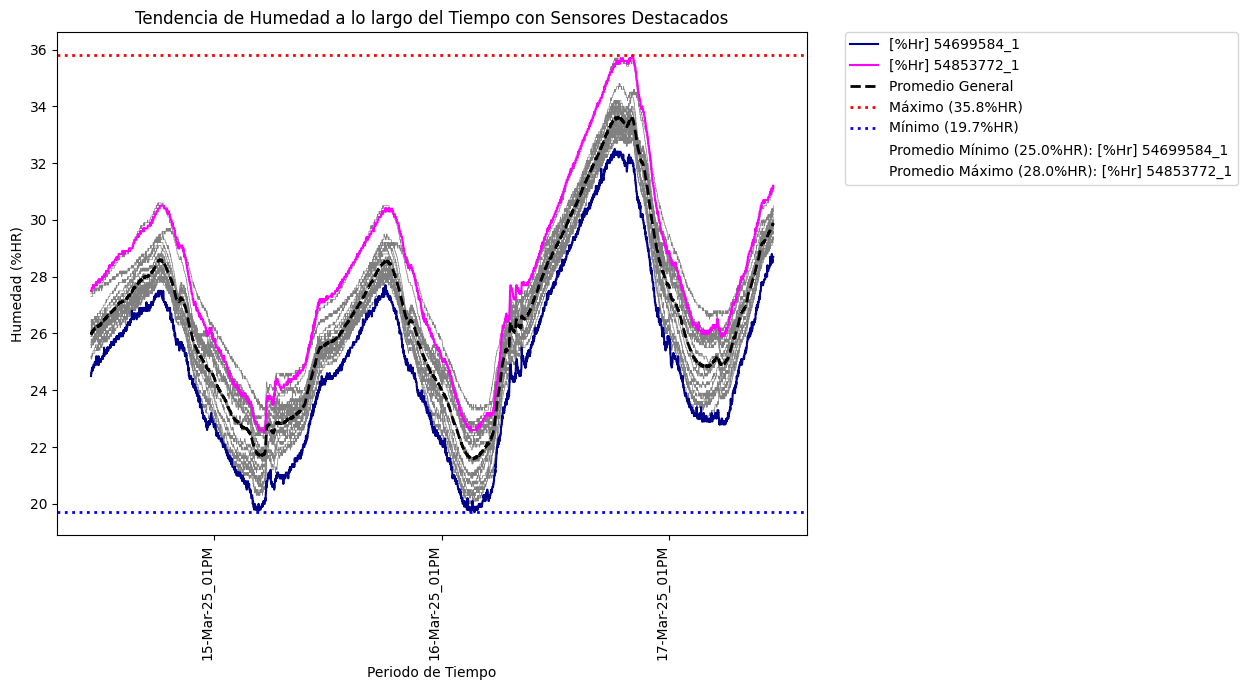

In [342]:
highlight_sensors_humidity_filtered = {
    overall_min_sensor_humidity: 'cyan',
    overall_max_sensor_humidity: 'darkred',
    min_average_sensor_humidity: 'darkblue',
    max_average_sensor_humidity: 'magenta'}
plt.figure(figsize=(15, 7))
plt.subplots_adjust(right=0.85)
for sensor in sensor_columns_humidity:
    plt.plot(df_humidity_filtered['Timestamp'], df_humidity_filtered[sensor], color='gray', linestyle='-', linewidth=0.5)
for sensor, color in highlight_sensors_humidity_filtered.items():
    if sensor in sensor_columns_humidity:
        plt.plot(df_humidity_filtered['Timestamp'], df_humidity_filtered[sensor], color=color, linestyle='-', linewidth=1.5, label=sensor)
plt.plot(df_humidity_filtered['Timestamp'], overall_average_humidity_filtered, label='Promedio General', linestyle='--', color='black', linewidth=2)
plt.axhline(y=overall_max_value_humidity, color='red', linestyle=':', linewidth=2, label=f'Máximo ({overall_max_value_humidity:.1f}%HR)')
plt.axhline(y=overall_min_value_humidity, color='blue', linestyle=':', linewidth=2, label=f'Mínimo ({overall_min_value_humidity:.1f}%HR)')
plt.title('Tendencia de Humedad a lo largo del Tiempo con Sensores Destacados')
plt.xlabel('Periodo de Tiempo')
plt.ylabel('Humedad (%HR)')
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b-%y_%I%p'))
ax.xaxis.set_major_locator(mdates.HourLocator(interval=24))
plt.xticks(rotation=90, ha='right')
legend_handles, legend_labels = ax.get_legend_handles_labels()
filtered_handles = []
filtered_labels = []
desired_labels = list(highlight_sensors_humidity_filtered.keys()) + ['Promedio General', f'Máximo ({overall_max_value_humidity:.1f}%HR)', f'Mínimo ({overall_min_value_humidity:.1f}%HR)']
for handle, label in zip(legend_handles, legend_labels):
    if label in desired_labels:
        filtered_handles.append(handle)
        filtered_labels.append(label)
additional_legend_info = [
    f"Promedio Mínimo ({min_average_value_humidity:.1f}%HR): {min_average_sensor_humidity}",
    f"Promedio Máximo ({max_average_value_humidity:.1f}%HR): {max_average_sensor_humidity}"]
dummy_handles = [plt.Line2D([0], [0], linestyle='none', label=info) for info in additional_legend_info]
all_handles = filtered_handles + dummy_handles
all_labels = filtered_labels + additional_legend_info
plt.legend(handles=all_handles, labels=all_labels, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

#Tendencias promedio con intervalos de puntos extremos

##Temperatura

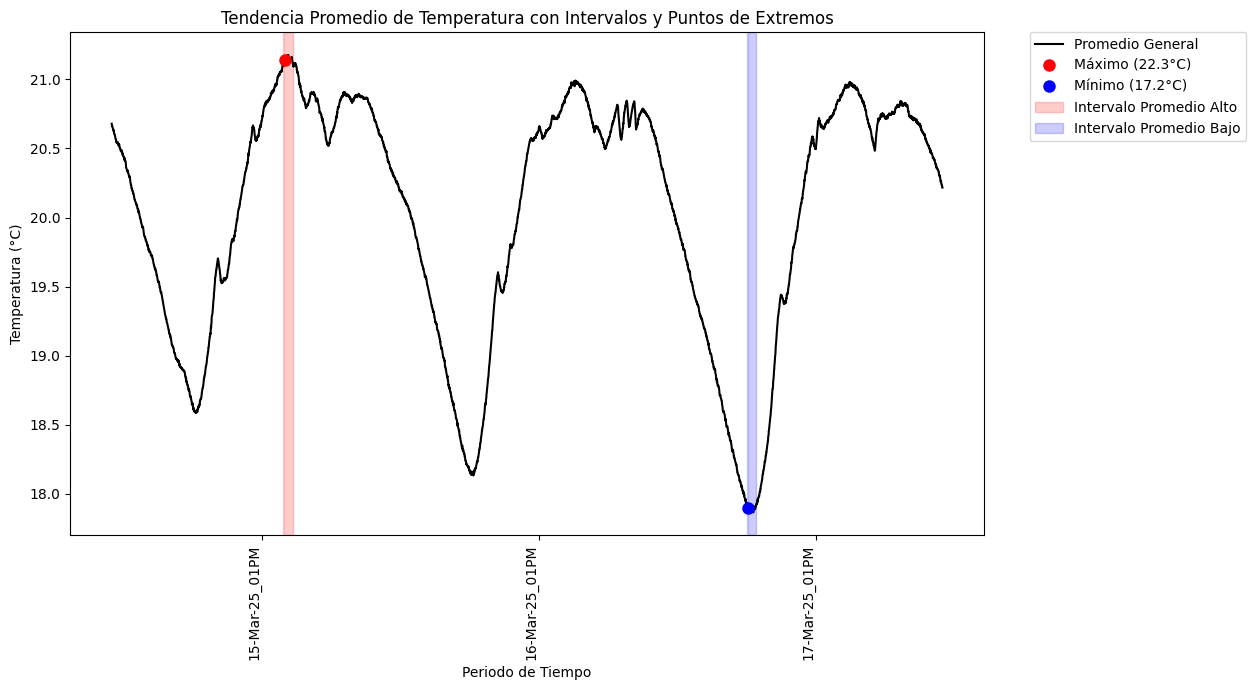

In [343]:
overall_max_value_temp_filtered = df_temp_filtered[sensor_columns_temp].max().max()
overall_min_value_temp_filtered = df_temp_filtered[sensor_columns_temp].min().min()
max_temp_timestamp_filtered = df_temp_filtered['Timestamp'][df_temp_filtered[sensor_columns_temp].stack().idxmax()[0]]
min_temp_timestamp_filtered = df_temp_filtered['Timestamp'][df_temp_filtered[sensor_columns_temp].stack().idxmin()[0]]
high_avg_threshold_temp = overall_average_temp_filtered.quantile(0.99)
low_avg_threshold_temp = overall_average_temp_filtered.quantile(0.01)
def find_contiguous_intervals(timestamps, delta=pd.Timedelta(minutes=1)):
    intervals = []
    if timestamps.empty:
        return intervals
    current_start = timestamps.iloc[0]
    current_end = timestamps.iloc[0]
    for ts in timestamps[1:]:
        if ts - current_end <= delta:
            current_end = ts
        else:
            intervals.append((current_start, current_end))
            current_start = ts
            current_end = ts
    intervals.append((current_start, current_end))
    return intervals
high_avg_contiguous_intervals_temp = find_contiguous_intervals(df_temp_filtered[overall_average_temp_filtered >= high_avg_threshold_temp]['Timestamp'].sort_values())
low_avg_contiguous_intervals_temp = find_contiguous_intervals(df_temp_filtered[overall_average_temp_filtered <= low_avg_threshold_temp]['Timestamp'].sort_values())
plt.figure(figsize=(15, 7))
plt.subplots_adjust(right=0.85)
plt.plot(df_temp_filtered['Timestamp'], overall_average_temp_filtered, label='Promedio General', linestyle='-', color='black', linewidth=1.5)
plt.plot(max_temp_timestamp_filtered, overall_average_temp_filtered[df_temp_filtered['Timestamp'] == max_temp_timestamp_filtered], 'ro', markersize=8, label=f'Máximo ({overall_max_value_temp_filtered:.1f}°C)')
plt.plot(min_temp_timestamp_filtered, overall_average_temp_filtered[df_temp_filtered['Timestamp'] == min_temp_timestamp_filtered], 'bo', markersize=8, label=f'Mínimo ({overall_min_value_temp_filtered:.1f}°C)')
for start, end in high_avg_contiguous_intervals_temp:
    plt.axvspan(start, end, color='red', alpha=0.2, label='Intervalo Promedio Alto' if start == high_avg_contiguous_intervals_temp[0][0] else "")
for start, end in low_avg_contiguous_intervals_temp:
    plt.axvspan(start, end, color='blue', alpha=0.2, label='Intervalo Promedio Bajo' if start == low_avg_contiguous_intervals_temp[0][0] else "")
plt.title('Tendencia Promedio de Temperatura con Intervalos y Puntos de Extremos')
plt.xlabel('Periodo de Tiempo')
plt.ylabel('Temperatura (°C)')
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b-%y_%I%p'))
ax.xaxis.set_major_locator(mdates.HourLocator(interval=24))
plt.xticks(rotation=90, ha='right')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

##Humedad


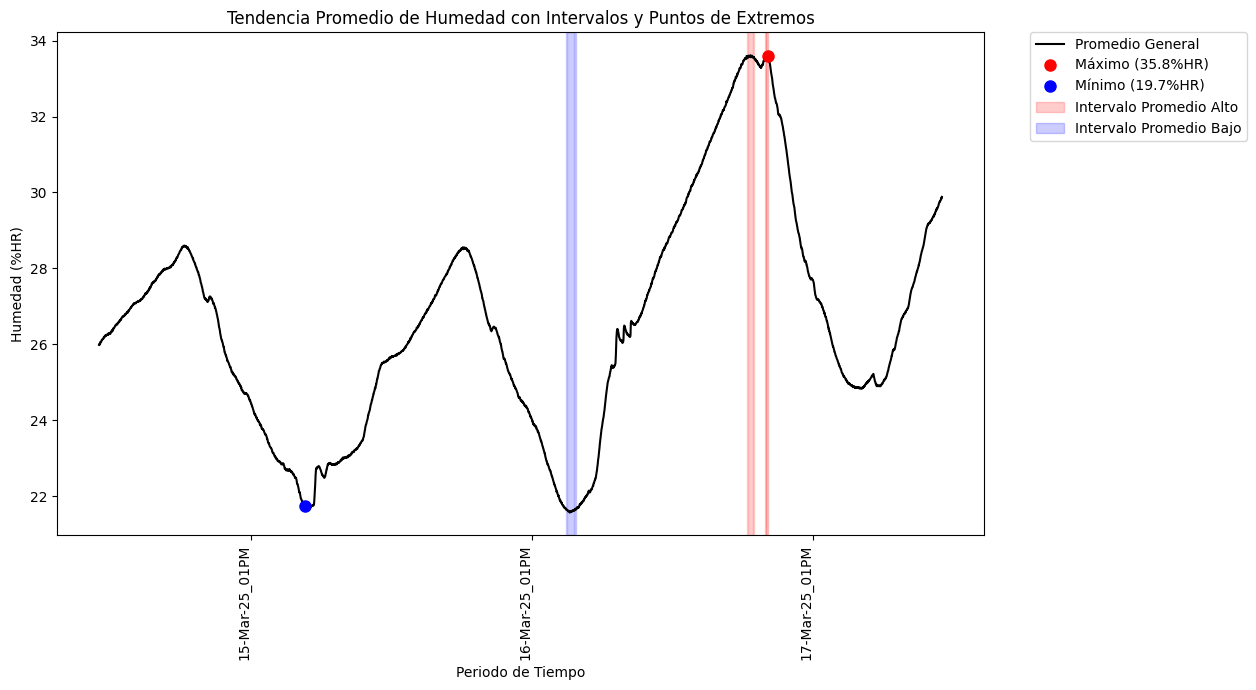

In [344]:
overall_max_value_humidity_filtered = df_humidity_filtered[sensor_columns_humidity].max().max()
overall_min_value_humidity_filtered = df_humidity_filtered[sensor_columns_humidity].min().min()
max_humidity_timestamp_filtered = df_humidity_filtered['Timestamp'][df_humidity_filtered[sensor_columns_humidity].stack().idxmax()[0]]
min_humidity_timestamp_filtered = df_humidity_filtered['Timestamp'][df_humidity_filtered[sensor_columns_humidity].stack().idxmin()[0]]
high_avg_threshold_humidity = overall_average_humidity_filtered.quantile(0.99)
low_avg_threshold_humidity = overall_average_humidity_filtered.quantile(0.01)
def find_contiguous_intervals(timestamps, delta=pd.Timedelta(minutes=1)):
    intervals = []
    if timestamps.empty:
        return intervals
    current_start = timestamps.iloc[0]
    current_end = timestamps.iloc[0]
    for ts in timestamps[1:]:
        if ts - current_end <= delta:
            current_end = ts
        else:
            intervals.append((current_start, current_end))
            current_start = ts
            current_end = ts
    intervals.append((current_start, current_end))
    return intervals
high_avg_contiguous_intervals_humidity = find_contiguous_intervals(df_humidity_filtered[overall_average_humidity_filtered >= high_avg_threshold_humidity]['Timestamp'].sort_values())
low_avg_contiguous_intervals_humidity = find_contiguous_intervals(df_humidity_filtered[overall_average_humidity_filtered <= low_avg_threshold_humidity]['Timestamp'].sort_values())
plt.figure(figsize=(15, 7))
plt.subplots_adjust(right=0.85)
plt.plot(df_humidity_filtered['Timestamp'], overall_average_humidity_filtered, label='Promedio General', linestyle='-', color='black', linewidth=1.5)
plt.plot(max_humidity_timestamp_filtered, overall_average_humidity_filtered[df_humidity_filtered['Timestamp'] == max_humidity_timestamp_filtered], 'ro', markersize=8, label=f'Máximo ({overall_max_value_humidity_filtered:.1f}%HR)')
plt.plot(min_humidity_timestamp_filtered, overall_average_humidity_filtered[df_humidity_filtered['Timestamp'] == min_humidity_timestamp_filtered], 'bo', markersize=8, label=f'Mínimo ({overall_min_value_humidity_filtered:.1f}%HR)')
for start, end in high_avg_contiguous_intervals_humidity:
    plt.axvspan(start, end, color='red', alpha=0.2, label='Intervalo Promedio Alto' if start == high_avg_contiguous_intervals_humidity[0][0] else "")
for start, end in low_avg_contiguous_intervals_humidity:
    plt.axvspan(start, end, color='blue', alpha=0.2, label='Intervalo Promedio Bajo' if start == low_avg_contiguous_intervals_humidity[0][0] else "")
plt.title('Tendencia Promedio de Humedad con Intervalos y Puntos de Extremos')
plt.xlabel('Periodo de Tiempo')
plt.ylabel('Humedad (%HR)')
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b-%y_%I%p'))
ax.xaxis.set_major_locator(mdates.HourLocator(interval=24))
plt.xticks(rotation=90, ha='right')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

#Tabla valores extremos general

In [345]:
for sensor in unique_sensors_temp:
    sensor_table_temp_df = df_grouped_extreme_temp[df_grouped_extreme_temp['Sensor'] == sensor].copy()
    if not sensor_table_temp_df.empty:
        print(f"\nTabla de valores extremos generales para el sensor (Temperatura): {sensor}")
        display(sensor_table_temp_df)
        total_frequency_temp = sensor_table_temp_df['Frecuencia'].sum()
        print(f"Suma total de frecuencia para el sensor {sensor} (Temperatura): {total_frequency_temp}\n")
for sensor in unique_sensors_humidity:
    sensor_table_humidity_df = df_grouped_extreme_humidity[df_grouped_extreme_humidity['Sensor'] == sensor].copy()
    if not sensor_table_humidity_df.empty:
        print(f"\nTabla de valores extremos generales para el sensor (Humedad): {sensor}")
        display(sensor_table_humidity_df)
        total_frequency_humidity = sensor_table_humidity_df['Frecuencia'].sum()
        print(f"Suma total de frecuencia para el sensor {sensor} (Humedad): {total_frequency_humidity}\n")


Tabla de valores extremos generales para el sensor (Temperatura): [°C] 54853838_2


,Sensor,Fecha,Hora (Rango),Valor Registrado,Frecuencia,Tipo
0,[°C] 54853838_2,2025-03-15,15:03:00-15:05:00,22.3,2,Máximo General
1,[°C] 54853838_2,2025-03-15,15:27:00-15:42:00,22.3,4,Máximo General


Suma total de frecuencia para el sensor [°C] 54853838_2 (Temperatura): 6


Tabla de valores extremos generales para el sensor (Temperatura): [°C] 54853789_2


,Sensor,Fecha,Hora (Rango),Valor Registrado,Frecuencia,Tipo
2,[°C] 54853789_2,2025-03-17,07:10:00-08:07:00,17.2,56,Mínimo General


Suma total de frecuencia para el sensor [°C] 54853789_2 (Temperatura): 56


Tabla de valores extremos generales para el sensor (Humedad): [%Hr] 54699584_1


,Sensor,Fecha,Hora (Rango),Valor Registrado,Frecuencia,Tipo
0,[%Hr] 54699584_1,2025-03-15,17:38:00,19.7,1,Mínimo General
1,[%Hr] 54699584_1,2025-03-16,16:04:00,19.7,1,Mínimo General
2,[%Hr] 54699584_1,2025-03-16,16:28:00,19.7,1,Mínimo General


Suma total de frecuencia para el sensor [%Hr] 54699584_1 (Humedad): 3


Tabla de valores extremos generales para el sensor (Humedad): [%Hr] 54853772_1


,Sensor,Fecha,Hora (Rango),Valor Registrado,Frecuencia,Tipo
3,[%Hr] 54853772_1,2025-03-17,09:07:00,35.8,1,Máximo General


Suma total de frecuencia para el sensor [%Hr] 54853772_1 (Humedad): 1



#Extras

##umbrales de valores extremos


In [346]:
print(f"\nUmbral para temperatura promedio alta (99th percentile): {high_avg_threshold_temp:.2f}°C")
print(f"Umbral para temperatura promedio baja (1st percentile): {low_avg_threshold_temp:.2f}°C")
print(f"\nUmbral para humedad promedio alta (99th percentile): {high_avg_threshold_humidity:.2f}%HR")
print(f"Umbral para humedad promedio baja (1st percentile): {low_avg_threshold_humidity:.2f}%HR")


Umbral para temperatura promedio alta (99th percentile): 21.12°C
Umbral para temperatura promedio baja (1st percentile): 17.92°C

Umbral para humedad promedio alta (99th percentile): 33.56%HR
Umbral para humedad promedio baja (1st percentile): 21.64%HR


##Tabla valores extremos individual

In [347]:
print("\n--- Tabla de valores extremos por sensor (Temperatura) FINAL ---")
display(df_grouped_extreme_temp)
print("\n--- Tabla de valores extremos por sensor (Humedad) FINAL ---")
display(df_grouped_extreme_humidity)


--- Tabla de valores extremos por sensor (Temperatura) FINAL ---


,Sensor,Fecha,Hora (Rango),Valor Registrado,Frecuencia,Tipo
0,[°C] 54853838_2,2025-03-15,15:03:00-15:05:00,22.3,2,Máximo General
1,[°C] 54853838_2,2025-03-15,15:27:00-15:42:00,22.3,4,Máximo General
2,[°C] 54853789_2,2025-03-17,07:10:00-08:07:00,17.2,56,Mínimo General



--- Tabla de valores extremos por sensor (Humedad) FINAL ---


,Sensor,Fecha,Hora (Rango),Valor Registrado,Frecuencia,Tipo
0,[%Hr] 54699584_1,2025-03-15,17:38:00,19.7,1,Mínimo General
1,[%Hr] 54699584_1,2025-03-16,16:04:00,19.7,1,Mínimo General
2,[%Hr] 54699584_1,2025-03-16,16:28:00,19.7,1,Mínimo General
3,[%Hr] 54853772_1,2025-03-17,09:07:00,35.8,1,Máximo General


##Análisis por sensor Temperatura

In [348]:
print("--- Análisis por Sensor (Temperatura) ---")
for sensor, stats in sensor_stats_temp.items():
    print(f"Sensor: {sensor}")
    print(f"  Valor Máximo: {stats['max_value']:.2f}, Frecuencia: {stats['max_frequency']}")
    print(f"  Valor Mínimo: {stats['min_value']:.2f}, Frecuencia: {stats['min_frequency']}")
    print(f"  Valor Promedio: {stats['average_value']:.2f}")
    print("-" * 30)
print("--- Resumen de Resultados General (Temperatura) ---")
print(f"Valor Máximo General de todos los sensores: {overall_max_value_temp:.1f} (Sensor: {overall_max_sensor_temp})")
print(f"Valor Mínimo General de todos los sensores: {overall_min_value_temp:.1f} (Sensor: {overall_min_sensor_temp})")
print(f"Valor Promedio Mínimo de todos los sensores: {min_average_value_temp:.1f} (Sensor: {min_average_sensor_temp})")
print(f"Valor Promedio Máximo de todos los sensores: {max_average_value_temp:.1f} (Sensor: {max_average_sensor_temp})")

--- Análisis por Sensor (Temperatura) ---
Sensor: [°C] 2775659_1
  Valor Máximo: 21.50, Frecuencia: 6
  Valor Mínimo: 18.00, Frecuencia: 35
  Valor Promedio: 20.32
------------------------------
Sensor: [°C] 54683879_2
  Valor Máximo: 22.10, Frecuencia: 4
  Valor Mínimo: 17.80, Frecuencia: 36
  Valor Promedio: 20.31
------------------------------
Sensor: [°C] 54699503_2
  Valor Máximo: 21.90, Frecuencia: 9
  Valor Mínimo: 17.70, Frecuencia: 66
  Valor Promedio: 20.17
------------------------------
Sensor: [°C] 54699584_2
  Valor Máximo: 21.60, Frecuencia: 32
  Valor Mínimo: 17.70, Frecuencia: 44
  Valor Promedio: 20.17
------------------------------
Sensor: [°C] 54699660_2
  Valor Máximo: 21.90, Frecuencia: 16
  Valor Mínimo: 17.60, Frecuencia: 39
  Valor Promedio: 20.29
------------------------------
Sensor: [°C] 54849765_2
  Valor Máximo: 20.70, Frecuencia: 156
  Valor Mínimo: 18.20, Frecuencia: 66
  Valor Promedio: 19.80
------------------------------
Sensor: [°C] 54849816_2
  Valor

##Análisis por sensor Humedad

In [349]:
print("--- Análisis por Sensor (Humedad) ---")
for sensor, stats in sensor_stats_humidity.items():
    print(f"Sensor: {sensor}")
    print(f"  Valor Máximo: {stats['max_value']:.2f}, Frecuencia: {stats['max_frequency']}")
    print(f"  Valor Mínimo: {stats['min_value']:.2f}, Frecuencia: {stats['min_frequency']}")
    print(f"  Valor Promedio: {stats['average_value']:.2f}")
    print("-" * 30)
print("--- Resumen de Resultados General (Humedad) ---")
print(f"Valor Máximo General de todos los sensores: {overall_max_value_humidity:.1f} (Sensor: {overall_max_sensor_humidity})")
print(f"Valor Mínimo General de todos los sensores: {overall_min_value_humidity:.1f} (Sensor: {overall_min_sensor_humidity})")
print(f"Valor Promedio Mínimo de todos los sensores: {min_average_value_humidity:.1f} (Sensor: {min_average_sensor_humidity})")
print(f"Valor Promedio Máximo de todos los sensores: {max_average_value_humidity:.1f} (Sensor: {max_average_sensor_humidity})")

--- Análisis por Sensor (Humedad) ---
Sensor: [%Hr] 54683879_1
  Valor Máximo: 33.30, Frecuencia: 2
  Valor Mínimo: 20.20, Frecuencia: 1
  Valor Promedio: 25.69
------------------------------
Sensor: [%Hr] 54699503_1
  Valor Máximo: 34.20, Frecuencia: 42
  Valor Mínimo: 20.90, Frecuencia: 7
  Valor Promedio: 26.63
------------------------------
Sensor: [%Hr] 54699584_1
  Valor Máximo: 32.50, Frecuencia: 1
  Valor Mínimo: 19.70, Frecuencia: 3
  Valor Promedio: 25.01
------------------------------
Sensor: [%Hr] 54699660_1
  Valor Máximo: 35.70, Frecuencia: 36
  Valor Mínimo: 22.00, Frecuencia: 4
  Valor Promedio: 27.72
------------------------------
Sensor: [%Hr] 54849765_1
  Valor Máximo: 33.10, Frecuencia: 13
  Valor Mínimo: 21.80, Frecuencia: 9
  Valor Promedio: 26.69
------------------------------
Sensor: [%Hr] 54849816_1
  Valor Máximo: 34.20, Frecuencia: 21
  Valor Mínimo: 21.60, Frecuencia: 2
  Valor Promedio: 26.97
------------------------------
Sensor: [%Hr] 54849826_1
  Valor M

##Generacion de Reporte

In [350]:
# REPORTE DE TEMPERATURA
import numpy as np
import pandas as pd
import re

# ----------------- Helpers de fechas en español -----------------
_MESES_ES = ["ene","feb","mar","abr","may","jun",
             "jul","ago","sep","oct","nov","dic"]

def fecha_es(dt: pd.Timestamp) -> str:
    if dt is None or pd.isna(dt):
        return ""
    return f"{dt.day:02d}/{_MESES_ES[dt.month-1]}/{dt.year}"

def fecha_hora_es(dt: pd.Timestamp) -> str:
    if dt is None or pd.isna(dt):
        return ""
    return f"{fecha_es(dt)} {dt.strftime('%H:%M:%S')}"

# ---- Helper para compactar rachas continuas (fuera de la función) ----
def compactar_eventos_contiguos(df_eventos,
                                column_name, # Added column_name parameter
                                step="1min",                 # "infer" o "1min", "5min", etc.
                                formato_fecha_in="%d/%m/%Y", # <-- cómo VIENE 'fecha' en df_eventos
                                formato_hora_in="%H:%M:%S"   # <-- cómo VIENE 'hora' en df_eventos
                                ):
    if df_eventos is None or df_eventos.empty:
        return pd.DataFrame(columns=["fecha_inicio","hora_inicio","fecha_fin","hora_fin",column_name,"n_registros"])

    # Parseo SIN warnings (especificamos el formato exacto)
    s = df_eventos["fecha"].astype(str).str.strip() + " " + df_eventos["hora"].astype(str).str.strip()
    fmt_in = f"{formato_fecha_in} {formato_hora_in}"
    dt = pd.to_datetime(s, format=fmt_in, errors="coerce")  # <- sin dayfirst

    mask = dt.notna()
    df = df_eventos.loc[mask].copy()
    df["_dt"] = dt[mask]
    df.sort_values("_dt", inplace=True)

    # Paso esperado entre timestamps
    if step == "infer":
        diffs = df["_dt"].diff().dropna()
        expected = diffs.mode().iloc[0] if not diffs.empty else pd.Timedelta(minutes=1)
    else:
        expected = pd.Timedelta(step)

    grp = (df["_dt"].diff() != expected).cumsum()

    out = df.groupby(grp).agg(
        dt_ini=("_dt", "first"),
        dt_fin=("_dt", "last"),
        # Use the provided column_name in aggregation
        **{column_name: (column_name, "first")},
        n_registros=("hora", "size")
    ).reset_index(drop=True)

    # Salida con mes en palabras (ES)
    out["fecha_inicio"] = out["dt_ini"].apply(fecha_es)
    out["hora_inicio"]  = out["dt_ini"].dt.strftime("%H:%M:%S")
    out["fecha_fin"]    = out["dt_fin"].apply(fecha_es)
    out["hora_fin"]     = out["dt_fin"].dt.strftime("%H:%M:%S")

    # Return the DataFrame with the specified column name
    return out[["fecha_inicio","hora_inicio","fecha_fin","hora_fin",column_name,"n_registros"]]


# ---- Tu función principal ----
def resumen_temperaturas(
    df,
    # Formato de ENTRADA en tu DataFrame original (para evitar warnings)
    formato_fecha_in="%Y-%m-%d",   # ej. ISO '2025-09-24'
    formato_hora_in="%H:%M:%S",    # ej. '14:30:00'
    # Formato que usarán df_max/df_min (entrada para la función de compactar)
    formato_fecha="%d/%m/%Y",
    formato_hora="%H:%M:%S",
    decimales_empate=2,
    tolerancia=None,
    Ea_kJ=83.144
):
    def safe_round(x, ndigits=None):
        if x is None:
            return None
        try:
            if isinstance(x, float) and np.isnan(x):
                return None
        except Exception:
            pass
        return round(x, ndigits) if ndigits is not None else round(x)

    cols_norm = {c: c.strip().lower() for c in df.columns}
    col_fecha = next((c for c, v in cols_norm.items() if v in ("fecha","date")), None)
    col_hora  = next((c for c, v in cols_norm.items() if v in ("hora","time")),  None)

    # Timestamp SIN warnings: especifica formato exacto de entrada
    ts = None
    if col_fecha and col_hora:
        s = df[col_fecha].astype(str).str.strip() + " " + df[col_hora].astype(str).str.strip()
        fmt_in = f"{formato_fecha_in} {formato_hora_in}"
        ts = pd.to_datetime(s, format=fmt_in, errors="coerce")

    fecha_inicio = ts.min() if ts is not None and ts.notna().any() else None
    fecha_final  = ts.max() if ts is not None and ts.notna().any() else None
    tiempo_total_td = (fecha_final - fecha_inicio) if (fecha_inicio is not None and fecha_final is not None) else None
    tiempo_total_horas = (tiempo_total_td.total_seconds()/3600) if tiempo_total_td is not None else None

    # Columnas de temperatura
    candidatos = [c for c in df.columns if c not in {col_fecha, col_hora}]
    temp_cols = []
    seen = set()
    for c in candidatos:
        if str(c).strip().startswith("[°C]") and c not in seen:
            temp_cols.append(c); seen.add(c)

    temps_num = df[temp_cols].apply(pd.to_numeric, errors="coerce") if temp_cols else pd.DataFrame()
    promedio_general = float(temps_num.stack().mean()) if not temps_num.empty else None

    # Promedio máximo por sensor (empates)
    sensores_prom_max = []
    promedio_sensor_prom_max = None
    if not temps_num.empty:
        medias = temps_num.mean(axis=0, skipna=True).dropna()
        if not medias.empty:
            if tolerancia is None:
                medias_r = medias.round(decimales_empate)
                max_val_r = float(medias_r.max())
                sensores_prom_max = medias_r.index[medias_r.eq(max_val_r)].tolist()
                promedio_sensor_prom_max = max_val_r
            else:
                max_val = float(medias.max())
                sensores_prom_max = medias.index[np.isclose(medias, max_val, atol=tolerancia)].tolist()
                promedio_sensor_prom_max = max_val

    # Promedio mínimo por sensor (empates)
    sensores_prom_min = []
    promedio_sensor_prom_min = None
    if not temps_num.empty:
        medias = temps_num.mean(axis=0, skipna=True).dropna()
        if not medias.empty:
            if tolerancia is None:
                medias_r = medias.round(decimales_empate)
                min_val_r = float(medias_r.min())
                sensores_prom_min = medias_r.index[medias_r.eq(min_val_r)].tolist()
                promedio_sensor_prom_min = min_val_r
            else:
                min_val = float(medias.min())
                sensores_prom_min = medias.index[np.isclose(medias, min_val, atol=tolerancia)].tolist()
                promedio_sensor_prom_min = min_val

    def _event_df(mask, valor, column_name): # Added column_name parameter
        if ts is None or mask.empty:
            return pd.DataFrame(columns=["fecha","hora",column_name,"n_sensores","sensores"])
        rows = mask.any(axis=1)
        if not rows.any():
            return pd.DataFrame(columns=["fecha","hora",column_name,"n_sensores","sensores"])
        ts_sel = ts.loc[rows]
        n_sen  = mask.loc[rows].sum(axis=1).astype(int)
        sensores = mask.loc[rows].apply(lambda r: r.index[r].tolist(), axis=1)
        out = pd.DataFrame({
            "fecha": ts_sel.dt.strftime(formato_fecha).values,  # -> p.ej. "24/09/2025"
            "hora":  ts_sel.dt.strftime(formato_hora).values,
            column_name: valor, # Use the provided column_name
            "n_sensores": n_sen.values,
            "sensores": sensores.values
        })
        return out.reset_index(drop=True)

    def _diff_max_instantanea(temps_num, ts):
        if temps_num.empty:
            return None
        validos_por_fila = temps_num.notna().sum(axis=1)
        row_range = temps_num.max(axis=1, skipna=True) - temps_num.min(axis=1, skipna=True)
        mask_rows = (validos_por_fila >= 2) & row_range.notna()
        if not mask_rows.any():
            return None
        return float(row_range[mask_rows].max())

    # Máximos y mínimos
    if not temps_num.empty:
        temp_max = float(temps_num.max().max())
        mask_max = temps_num.eq(temp_max)
        df_max = _event_df(mask_max, temp_max, "temperatura") # Pass column_name
        repeticiones_max = int(mask_max.sum().sum())

        temp_min = float(temps_num.min().min())
        mask_min = temps_num.eq(temp_min)
        df_min = _event_df(mask_min, temp_min, "temperatura") # Pass column_name
        repeticiones_min = int(mask_min.sum().sum())
    else:
        temp_max = temp_min = None
        repeticiones_max = repeticiones_min = 0
        df_max = pd.DataFrame(columns=["fecha","hora","temperatura","n_sensores","sensores"])
        df_min = pd.DataFrame(columns=["fecha","hora","temperatura","n_sensores","sensores"])

    dif_max_inst = _diff_max_instantanea(temps_num, ts)

    # MKT por sensor (máximo y mínimo con empates)
    sensores_mkt_max = []; mkt_max_val = None
    sensores_mkt_min = []; mkt_min_val = None
    if not temps_num.empty:
        R_kJ = 0.008314462618
        Ea_over_R = Ea_kJ / R_kJ

        def mkt_col(series_celsius):
            vals = pd.to_numeric(series_celsius, errors="coerce").to_numpy(dtype=float)
            vals = vals[~np.isnan(vals)]
            if vals.size == 0:
                return np.nan
            TK = vals + 273.15
            arr = np.exp(-Ea_over_R / TK)
            m = arr.mean()
            if not np.isfinite(m) or m <= 0:
                return np.nan
            TK_mkt = Ea_over_R / (-np.log(m))
            return TK_mkt - 273.15

        mkt_series = pd.Series({c: mkt_col(df[c]) for c in temp_cols}).dropna()
        if not mkt_series.empty:
            if tolerancia is None:
                mkt_r = mkt_series.round(decimales_empate)
                mkt_max_val = float(mkt_r.max());  sensores_mkt_max = mkt_r.index[mkt_r.eq(mkt_max_val)].tolist()
                mkt_min_val = float(mkt_r.min());  sensores_mkt_min = mkt_r.index[mkt_r.eq(mkt_min_val)].tolist()
            else:
                mkt_max_raw = float(mkt_series.max()); mkt_max_val = mkt_max_raw
                sensores_mkt_max = mkt_series.index[np.isclose(mkt_series, mkt_max_raw, atol=tolerancia)].tolist()
                mkt_min_raw = float(mkt_series.min()); mkt_min_val = mkt_min_raw
                sensores_mkt_min = mkt_series.index[np.isclose(mkt_series, mkt_min_raw, atol=tolerancia)].tolist()

    # Resumen con fechas en español (strings)
    resumen_temp = {
        "Parametro                        Resultado"
        "\n------------------------------------------------": "",
        "\nfecha_hora_inicio              ": fecha_hora_es(fecha_inicio),
        "\nfecha_hora_final.              ": fecha_hora_es(fecha_final),
        "\ntiempo_total_horas.            ": safe_round(tiempo_total_horas, 1),
        "\ncantidad de sensores utilizados": len(temp_cols),
        "\ntemperatura promedio.          ": safe_round(promedio_general, 1),
        "\ntemperatura_maxima.            ": temp_max,
        "\nrepeticiones_temperatura_maxima": repeticiones_max,
        "\ntemperatura_minima.            ": temp_min,
        "\nrepeticiones_temperatura_minima": repeticiones_min,
        "\ndiferencia_maxima_instantanea. ": safe_round(dif_max_inst, 1),

        "\ntemperatura_promedio_maxima.   ": safe_round(promedio_sensor_prom_max, 1),
        "\nsensores_promedio_maximo.      ": sensores_prom_max,
        "\ntemperatura_promedio_minima.   ": safe_round(promedio_sensor_prom_min, 1),
        "\nsensores_promedio_minimo.      ": sensores_prom_min,

        "\nmkt maximo.                    ": safe_round(mkt_max_val, 1),
        "\nsensores_mkt_maximo.           ": sensores_mkt_max,
        "\nmkt_minimo.                    ": safe_round(mkt_min_val, 1),
        "\nsensores_mkt_minimo.           ": sensores_mkt_min,
    }
    return resumen_temp, temp_cols, df_max, df_min

In [351]:
# ======================= REPORTE HUMEDAD =======================
import numpy as np
import pandas as pd
import re

# ----------------- Helpers de fechas en español -----------------
_MESES_ES = ["enero","febrero","marzo","abril","mayo","junio",
             "julio","agosto","septiembre","octubre","noviembre","diciembre"]

def fecha_es(dt: pd.Timestamp) -> str:
    if dt is None or pd.isna(dt):
        return ""
    return f"{dt.day:02d} de {_MESES_ES[dt.month-1]} de {dt.year}"

def fecha_hora_es(dt: pd.Timestamp) -> str:
    if dt is None or pd.isna(dt):
        return ""
    return f"{fecha_es(dt)} {dt.strftime('%H:%M:%S')}"

# ---- Helper para compactar rachas continuas (fuera de la función) ----
def compactar_eventos_contiguos(df_eventos,
                                column_name, # Added column_name parameter
                                step="1min",                   # "infer" o "1min", "5min", etc.
                                formato_fecha_in="%d/%m/%Y",   # <-- cómo VIENE 'fecha' en df_eventos
                                formato_hora_in="%H:%M:%S"     # <-- cómo VIENE 'hora'  en df_eventos
                                ):
    """
    Espera df_eventos con columnas: ["fecha","hora","humedad", ...]
    Devuelve fechas en español y mantiene la columna 'humedad'.
    """
    if df_eventos is None or df_eventos.empty:
        # Use the provided column_name
        return pd.DataFrame(columns=["fecha_inicio","hora_inicio","fecha_fin","hora_fin",column_name,"n_registros"])

    # Parseo SIN warnings (se especifica el formato exacto)
    s = df_eventos["fecha"].astype(str).str.strip() + " " + df_eventos["hora"].astype(str).str.strip()
    fmt_in = f"{formato_fecha_in} {formato_hora_in}"
    dt = pd.to_datetime(s, format=fmt_in, errors="coerce")

    mask = dt.notna()
    df = df_eventos.loc[mask].copy()
    df["_dt"] = dt[mask]
    df.sort_values("_dt", inplace=True)

    # Paso esperado entre timestamps
    if step == "infer":
        diffs = df["_dt"].diff().dropna()
        expected = diffs.mode().iloc[0] if not diffs.empty else pd.Timedelta(minutes=1)
    else:
        expected = pd.Timedelta(step)

    grp = (df["_dt"].diff() != expected).cumsum()

    out = df.groupby(grp).agg(
        dt_ini=("_dt", "first"),
        dt_fin=("_dt", "last"),
        # Use the provided column_name in aggregation
        **{column_name: (column_name, "first")},
        n_registros=("hora", "size")
    ).reset_index(drop=True)

    # Salida con fechas en español
    out["fecha_inicio"] = out["dt_ini"].apply(fecha_es)
    out["hora_inicio"]  = out["dt_ini"].dt.strftime("%H:%M:%S")
    out["fecha_fin"]    = out["dt_fin"].apply(fecha_es)
    out["hora_fin"]     = out["dt_fin"].dt.strftime("%H:%M:%S")

    # Return the DataFrame with the specified column name
    return out[["fecha_inicio","hora_inicio","fecha_fin","hora_fin",column_name,"n_registros"]]


# ---- Función principal ----
def resumen_humedad(
    df,
    # Formato de ENTRADA real de tu DataFrame (para evitar warnings)
    formato_fecha_in="%Y-%m-%d",   # ej. '2025-03-19'
    formato_hora_in="%H:%M:%S",    # ej. '14:30:00'
    # Formato que se imprimirá en df_max/df_min (para luego compactar)
    formato_fecha="%d/%m/%Y",
    formato_hora="%H:%M:%S",
    decimales_empate=2,
    tolerancia=None
):
    def safe_round(x, ndigits=None):
        if x is None:
            return None
        try:
            if isinstance(x, float) and np.isnan(x):
                return None
        except Exception:
            pass
        return round(x, ndigits) if ndigits is not None else round(x)

    # Detectar columnas fecha/hora
    cols_norm = {c: c.strip().lower() for c in df.columns}
    col_fecha = next((c for c, v in cols_norm.items() if v in ("fecha","date")), None)
    col_hora  = next((c for c, v in cols_norm.items() if v in ("hora","time")),  None)

    # Timestamp SIN warnings: especifica formato de entrada
    ts = None
    if col_fecha and col_hora:
        s = df[col_fecha].astype(str).str.strip() + " " + df[col_hora].astype(str).str.strip()
        fmt_in = f"{formato_fecha_in} {formato_hora_in}"
        ts = pd.to_datetime(s, format=fmt_in, errors="coerce")

    fecha_inicio = ts.min() if ts is not None and ts.notna().any() else None
    fecha_final  = ts.max() if ts is not None and ts.notna().any() else None
    tiempo_total_td = (fecha_final - fecha_inicio) if (fecha_inicio is not None and fecha_final is not None) else None
    tiempo_total_horas = (tiempo_total_td.total_seconds()/3600) if tiempo_total_td is not None else None

    # Detectar columnas de HUMEDAD (prefijo "[%Hr]" u otra variante; case-insensitive)
    candidatos = [c for c in df.columns if c not in {col_fecha, col_hora}]
    hum_cols = []
    seen = set()
    for c in candidatos:
        if str(c).strip().lower().startswith("[%hr]") and c not in seen:
            hum_cols.append(c); seen.add(c)

    hum_num = df[hum_cols].apply(pd.to_numeric, errors="coerce") if hum_cols else pd.DataFrame()
    promedio_general = float(hum_num.stack().mean()) if not hum_num.empty else None

    # Promedio máximo por sensor (empates)
    sensores_prom_max = []
    promedio_sensor_prom_max = None
    if not hum_num.empty:
        medias = hum_num.mean(axis=0, skipna=True).dropna()
        if not medias.empty:
            if tolerancia is None:
                medias_r = medias.round(decimales_empate)
                max_val_r = float(medias_r.max())
                sensores_prom_max = medias_r.index[medias_r.eq(max_val_r)].tolist()
                promedio_sensor_prom_max = max_val_r
            else:
                max_val = float(medias.max())
                sensores_prom_max = medias.index[np.isclose(medias, max_val, atol=tolerancia)].tolist()
                promedio_sensor_prom_max = max_val

    # Promedio mínimo por sensor (empates)
    sensores_prom_min = []
    promedio_sensor_prom_min = None
    if not hum_num.empty:
        medias = hum_num.mean(axis=0, skipna=True).dropna()
        if not medias.empty:
            if tolerancia is None:
                medias_r = medias.round(decimales_empate)
                min_val_r = float(medias_r.min())
                sensores_prom_min = medias_r.index[medias_r.eq(min_val_r)].tolist()
                promedio_sensor_prom_min = min_val_r
            else:
                min_val = float(medias.min())
                sensores_prom_min = medias.index[np.isclose(medias, min_val, atol=tolerancia)].tolist()
                promedio_sensor_prom_min = min_val

    # --- construir DataFrames de eventos (AHORA con columna 'humedad') ---
    def _event_df(mask, valor, column_name): # Added column_name parameter
        if ts is None or mask.empty:
            # Use the provided column_name
            return pd.DataFrame(columns=["fecha","hora",column_name,"n_sensores","sensores"])
        rows = mask.any(axis=1)
        if not rows.any():
            # Use the provided column_name
            return pd.DataFrame(columns=["fecha","hora",column_name,"n_sensores","sensores"])
        ts_sel = ts.loc[rows]
        n_sen  = mask.loc[rows].sum(axis=1).astype(int)
        sensores = mask.loc[rows].apply(lambda r: r.index[r].tolist(), axis=1)
        out = pd.DataFrame({
            "fecha": ts_sel.dt.strftime(formato_fecha).values,  # p.ej. 24/09/2025
            "hora":  ts_sel.dt.strftime(formato_hora).values,
            column_name: valor, # Use the provided column_name
            "n_sensores": n_sen.values,
            "sensores": sensores.values
        })
        return out.reset_index(drop=True)

    # Diferencia máxima instantánea (entre sensores por fila)
    def _diff_max_instantanea(hum_num, ts):
        if hum_num.empty:
            return None
        validos_por_fila = hum_num.notna().sum(axis=1)
        row_range = hum_num.max(axis=1, skipna=True) - hum_num.min(axis=1, skipna=True)
        mask_rows = (validos_por_fila >= 2) & row_range.notna()
        if not mask_rows.any():
            return None
        return float(row_range[mask_rows].max())

    # Máximos/mínimos globales (tablas con 'humedad')
    if not hum_num.empty:
        h_max = float(hum_num.max().max())
        mask_max = hum_num.eq(h_max)
        df_max = _event_df(mask_max, h_max, "humedad") # Pass column_name
        repeticiones_max = int(mask_max.sum().sum())

        h_min = float(hum_num.min().min())
        mask_min = hum_num.eq(h_min)
        df_min = _event_df(mask_min, h_min, "humedad") # Pass column_name
        repeticiones_min = int(mask_min.sum().sum())
    else:
        h_max = h_min = None
        repeticiones_max = repeticiones_min = 0
        df_max = pd.DataFrame(columns=["fecha","hora","humedad","n_sensores","sensores"])
        df_min = pd.DataFrame(columns=["fecha","hora","humedad","n_sensores","sensores"])

    dif_max_inst = _diff_max_instantanea(hum_num, ts)

    # Resumen (fechas en español)
    resumen_hum = {


        "\nhumedad promedio.              ": safe_round(promedio_general, 1),
        "\nhumedad_maxima.                ": h_max,
        "\nrepeticiones_humedad_maxima.   ": repeticiones_max,
        "\nhumedad_minima.                ": h_min,
        "\nrepeticiones_humedad_minima.   ": repeticiones_min,
        "\ndiferencia_maxima_instantanea. ": safe_round(dif_max_inst, 1),

        "\nhumedad_promedio_maxima.       ": safe_round(promedio_sensor_prom_max, 1),
        "\nsensores_promedio_maximo.      ": sensores_prom_max,
        "\nhumedad_promedio_minima.       ": safe_round(promedio_sensor_prom_min, 1),
        "\nsensores_promedio_minimo.      ": sensores_prom_min,
    }
    return resumen_hum, hum_cols, df_max, df_min

##Reporte

In [352]:
resumen_temp, columnas_temperatura, df_max_temp, df_min_temp = resumen_temperaturas( # Changed variable names
    df_temp,
    formato_fecha_in="%Y-%m-%d",  # <-- AJUSTA A TU ENTRADA REAL
    formato_hora_in="%H:%M:%S",   # <-- AJUSTA A TU ENTRADA REAL
    formato_fecha="%d/%m/%Y",     # df_max/df_min (entrada para compactar)
    formato_hora="%H:%M:%S",
    decimales_empate=1,
    tolerancia=None,
    Ea_kJ=83.144
)
resumen_hum, columnas_humedad, df_max_hum, df_min_hum = resumen_humedad( # Changed variable names
    df_humidity,                     # <-- tu DataFrame de humedad
    formato_fecha_in="%Y-%m-%d",     # <-- AJUSTA a tu entrada real
    formato_hora_in="%H:%M:%S",      # <-- AJUSTA a tu entrada real
    formato_fecha="%d/%m/%Y",        # para df_max/df_min
    formato_hora="%H:%M:%S",
    decimales_empate=1,
    tolerancia=None
)

print("=== Resumen ===")
for k, v in resumen_temp.items():
    print(f"{k}: {v}")
for k, v in resumen_hum.items():
    print(f"{k}: {v}")

print("\nTabla Repetición Máxima (Temperatura compactada):") # Updated print statement
df_max_temp_comp = compactar_eventos_contiguos(df_max_temp, "temperatura", step="1min", # Added column_name
                                          formato_fecha_in="%d/%m/%Y",
                                          formato_hora_in="%H:%M:%S")
print(df_max_temp_comp.to_string())

print("\nTabla Repetición Mínima (Temperatura compactada):") # Updated print statement
df_min_temp_comp = compactar_eventos_contiguos(df_min_temp, "temperatura", step="1min", # Added column_name
                                          formato_fecha_in="%d/%m/%Y",
                                          formato_hora_in="%H:%M:%S")
print(df_min_temp_comp.to_string())

print("\nTabla Repetición Máxima (Humedad compactada):") # Updated print statement
df_max_hum_comp = compactar_eventos_contiguos(df_max_hum, "humedad", step="1min", # Added column_name
                                            formato_fecha_in="%d/%m/%Y",
                                            formato_hora_in="%H:%M:%S")
print(df_max_hum_comp.to_string())

print("\nTabla Repetición Mínima (Humedad compactada):") # Updated print statement
df_min_hum_comp = compactar_eventos_contiguos(df_min_hum, "humedad", step="1min", # Added column_name
                                            formato_fecha_in="%d/%m/%Y",
                                            formato_hora_in="%H:%M:%S")
print(df_min_hum_comp.to_string())

=== Resumen ===
Parametro                        Resultado
------------------------------------------------: 

fecha_hora_inicio              : 15 de marzo de 2025 00:00:00

fecha_hora_final.              : 18 de marzo de 2025 00:00:00

tiempo_total_horas.            : 72.0

cantidad de sensores utilizados: 24

temperatura promedio.          : 20.0

temperatura_maxima.            : 22.3

repeticiones_temperatura_maxima: 6

temperatura_minima.            : 17.2

repeticiones_temperatura_minima: 56

diferencia_maxima_instantanea. : 2.3

temperatura_promedio_maxima.   : 20.3

sensores_promedio_maximo.      : ['[°C] 2775659_1', '[°C] 54683879_2', '[°C] 54699660_2', '[°C] 54853789_2', '[°C] 54853838_2']

temperatura_promedio_minima.   : 19.6

sensores_promedio_minimo.      : ['[°C] 54853758_2']

mkt maximo.                    : 20.4

sensores_mkt_maximo.           : ['[°C] 2775659_1', '[°C] 54683879_2', '[°C] 54699660_2', '[°C] 54853789_2', '[°C] 54853838_2']

mkt_minimo.                   

##Mapeo

In [353]:
#===================== MAPEO =====================
import re
import numpy as np
import pandas as pd

# --------- helpers de IDs / niveles / ubicación ----------
def id_solo(colname: str) -> str:
    m = re.search(r"(\d+)", str(colname))
    return m.group(1) if m else str(colname).strip()

def nivel_de(sensor_id: str, level_override: dict) -> int | None:
    sid = id_solo(sensor_id)
    return int(level_override.get(sid)) if sid in level_override else None

def ubicacion_text(nivel: int | None, level_meters: dict) -> str:
    if nivel is None:
        return "Nivel desconocido"
    mts = level_meters.get(int(nivel))
    return f"Nivel {nivel} -> {mts:.2f} m a N.P.T." if mts is not None else f"Nivel {nivel}"

def detectar_cols(df: pd.DataFrame, prefijo: str) -> list[str]:
    pref = prefijo.lower()
    return [c for c in df.columns if str(c).strip().lower().startswith(pref)]

# --------- MKT (Mean Kinetic Temperature) ----------
def mkt_celsius(vals_c, Ea_kJ=83.144):
    vals = pd.to_numeric(pd.Series(vals_c), errors="coerce").to_numpy(dtype=float)
    vals = vals[np.isfinite(vals)]
    if vals.size == 0:
        return np.nan
    R_kJ = 0.008314462618
    Ea_over_R = Ea_kJ / R_kJ
    TK = vals + 273.15
    arr = np.exp(-Ea_over_R / TK)
    m = arr.mean()
    if not np.isfinite(m) or m <= 0:
        return np.nan
    TK_mkt = Ea_over_R / (-np.log(m))
    return TK_mkt - 273.15

# --------- empates por redondeo o tolerancia ----------
def elegir_extremo(series: pd.Series, modo: str, dec=1, tol=None):
    """
    series: index=sensor, values=valor
    modo: 'max' o 'min'
    Devuelve (lista_ids_empate, valor_elegido)
    """
    s = series.dropna()
    if s.empty:
        return [], np.nan
    if tol is None:
        s_r = s.round(dec)
        val = s_r.max() if modo == "max" else s_r.min()
        ids = s_r.index[s_r.eq(val)].tolist()
        return ids, float(val)
    else:
        base = s.max() if modo == "max" else s.min()
        ids = s.index[np.isclose(s, base, atol=tol)].tolist()
        return ids, float(base)

# ===================== FUNCIÓN PRINCIPAL =====================
def reporte_sin_mapa(
    df_temp: pd.DataFrame,
    df_hum: pd.DataFrame,
    *,
    col_ts_temp="Timestamp",
    col_ts_hum="Timestamp",
    t_ini: str | None = None,
    t_fin: str | None = None,
    level_override: dict | None = None,  # {'54853546': 3, ...}
    level_meters: dict | None = None,    # {1:0.80, 2:6.12, 3:9.80}
    decimales_empate=1,
    tolerancia=None,
    Ea_kJ=83.144
):
    """
    Regresa un dict con:
      - texto_temperatura (con empatados)
      - texto_humedad (con empatados)
      - texto_criticos
      - estructuras crudas: temperatura, humedad
    """
    level_override = level_override or {}
    level_meters   = level_meters   or {1:0.80, 2:6.12, 3:9.80}

    # --- normalización y filtro por periodo ---
    dft = df_temp.copy()
    dfh = df_hum.copy()
    dft[col_ts_temp] = pd.to_datetime(dft[col_ts_temp], errors="coerce")
    dfh[col_ts_hum]  = pd.to_datetime(dfh[col_ts_hum],  errors="coerce")
    dft = dft.dropna(subset=[col_ts_temp]).sort_values(col_ts_temp)
    dfh = dfh.dropna(subset=[col_ts_hum]).sort_values(col_ts_hum)

    if t_ini and t_fin:
        ti = pd.to_datetime(t_ini, errors="coerce")
        tf = pd.to_datetime(t_fin, errors="coerce")
        if pd.notna(ti) and pd.notna(tf):
            if ti > tf: ti, tf = tf, ti
            dft = dft[(dft[col_ts_temp] >= ti) & (dft[col_ts_temp] <= tf)]
            dfh = dfh[(dfh[col_ts_hum]  >= ti) & (dfh[col_ts_hum]  <= tf)]
    if dft.empty: raise ValueError("Sin datos de temperatura en el periodo.")
    if dfh.empty: raise ValueError("Sin datos de humedad en el periodo.")

    # --- detectar columnas ---
    cols_temp = detectar_cols(dft, "[°c]")
    cols_hum  = detectar_cols(dfh, "[%hr]")
    if not cols_temp: raise ValueError("No se encontraron columnas de temperatura '[°C] ...'.")
    if not cols_hum:  raise ValueError("No se encontraron columnas de humedad '[%Hr] ...'.")

    # --- numéricos ---
    Tnum = dft[cols_temp].apply(pd.to_numeric, errors="coerce")
    Hnum = dfh[cols_hum].apply(pd.to_numeric, errors="coerce")

    # --- medias por sensor ---
    t_mean = Tnum.mean(axis=0, skipna=True)
    h_mean = Hnum.mean(axis=0, skipna=True)

    # --- extremos instantáneos (globales) ---
    t_max_val = float(np.nanmax(Tnum.to_numpy()))
    t_min_val = float(np.nanmin(Tnum.to_numpy()))
    t_max_mask = Tnum.eq(t_max_val).any(axis=0)
    t_min_mask = Tnum.eq(t_min_val).any(axis=0)
    t_max_ids = t_max_mask.index[t_max_mask].tolist()
    t_min_ids = t_min_mask.index[t_min_mask].tolist()

    h_max_val = float(np.nanmax(Hnum.to_numpy()))
    h_min_val = float(np.nanmin(Hnum.to_numpy()))
    h_max_mask = Hnum.eq(h_max_val).any(axis=0)
    h_min_mask = Hnum.eq(h_min_val).any(axis=0)
    h_max_ids = h_max_mask.index[h_max_mask].tolist()
    h_min_ids = h_min_mask.index[h_min_mask].tolist()

    # --- extremos de PROMEDIO por sensor ---
    t_avg_max_ids, t_avg_max_val = elegir_extremo(t_mean, "max", decimales_empate, tolerancia)
    t_avg_min_ids, t_avg_min_val = elegir_extremo(t_mean, "min", decimales_empate, tolerancia)
    h_avg_max_ids, h_avg_max_val = elegir_extremo(h_mean, "max", decimales_empate, tolerancia)
    h_avg_min_ids, h_avg_min_val = elegir_extremo(h_mean, "min", decimales_empate, tolerancia)

    # --- MKT por sensor (temperatura) ---
    t_mkt = pd.Series({c: mkt_celsius(dft[c], Ea_kJ=Ea_kJ) for c in cols_temp})
    mkt_max_ids, mkt_max_val = elegir_extremo(t_mkt, "max", decimales_empate, tolerancia)
    mkt_min_ids, mkt_min_val = elegir_extremo(t_mkt, "min", decimales_empate, tolerancia)

    pick = lambda ids: sorted(ids)[0] if ids else ""

    temp_res = {
        "max":    {"ids": t_max_ids,     "id": pick(t_max_ids),     "valor": t_max_val},
        "min":    {"ids": t_min_ids,     "id": pick(t_min_ids),     "valor": t_min_val},
        "avg_max":{"ids": t_avg_max_ids, "id": pick(t_avg_max_ids), "valor": t_avg_max_val},
        "avg_min":{"ids": t_avg_min_ids, "id": pick(t_avg_min_ids), "valor": t_avg_min_val},
        "mkt_max":{"ids": mkt_max_ids,   "id": pick(mkt_max_ids),   "valor": mkt_max_val},
        "mkt_min":{"ids": mkt_min_ids,   "id": pick(mkt_min_ids),   "valor": mkt_min_val},
    }
    hum_res = {
        "max":    {"ids": h_max_ids,     "id": pick(h_max_ids),     "valor": h_max_val},
        "min":    {"ids": h_min_ids,     "id": pick(h_min_ids),     "valor": h_min_val},
        "avg_max":{"ids": h_avg_max_ids, "id": pick(h_avg_max_ids), "valor": h_avg_max_val},
        "avg_min":{"ids": h_avg_min_ids, "id": pick(h_avg_min_ids), "valor": h_avg_min_val},
    }

    # ---------- BLOQUES CON EMPATADOS ----------
    def bloque_con_empatados(res_dict, clave, titulo, sufijo):
        info = res_dict[clave]
        main_id = info["id"]
        valor   = info["valor"]
        ids_all = info["ids"] or ([main_id] if main_id else [])

        lines = [
            f"{titulo}: {valor:.1f}{sufijo}",
            f"Sensor: {id_solo(main_id)}",
            f"Ubicación: {ubicacion_text(nivel_de(main_id, level_override), level_meters)}",
        ]

        empatados = [sid for sid in ids_all if sid != main_id]
        if empatados:
            lines.append("Empatados:")
            for sid in sorted(empatados):
                lines.append(
                    f"  - Sensor: {id_solo(sid)}  |  {ubicacion_text(nivel_de(sid, level_override), level_meters)}"
                )
        return "\n".join(lines)

    # --- textos finales (con empatados) ---
    texto_temperatura = "\n\n".join([
        bloque_con_empatados(temp_res, "max",     "Temperatura Máxima",        " °C"),
        bloque_con_empatados(temp_res, "min",     "Temperatura Mínima",        " °C"),
        bloque_con_empatados(temp_res, "avg_max", "Temperatura Promedio Máx.", " °C"),
        bloque_con_empatados(temp_res, "avg_min", "Temperatura Promedio Mín.", " °C"),
        bloque_con_empatados(temp_res, "mkt_max", "MKT Máx.",                  " °C"),
        bloque_con_empatados(temp_res, "mkt_min", "MKT Mín.",                  " °C"),
    ])

    texto_humedad = "\n\n".join([
        bloque_con_empatados(hum_res, "max",     "Humedad Máxima",           " %HR"),
        bloque_con_empatados(hum_res, "min",     "Humedad Mínima",           " %HR"),
        bloque_con_empatados(hum_res, "avg_max", "Humedad Máx. Promedio",    " %HR"),
        bloque_con_empatados(hum_res, "avg_min", "Humedad Mín. Promedio",    " %HR"),
    ])

    texto_criticos = "\n\n".join([
        f"Punto crítico caliente\nSensor: {id_solo(temp_res['max']['id'])}\n"
        f"Ubicación: {ubicacion_text(nivel_de(temp_res['max']['id'], level_override), level_meters)}",
        f"Punto crítico frío\nSensor: {id_solo(temp_res['min']['id'])}\n"
        f"Ubicación: {ubicacion_text(nivel_de(temp_res['min']['id'], level_override), level_meters)}",
        f"Punto crítico humedad\nSensor: {id_solo(hum_res['max']['id'])}\n"
        f"Ubicación: {ubicacion_text(nivel_de(hum_res['max']['id'], level_override), level_meters)}",
    ])

    return {
        "texto_temperatura": texto_temperatura,
        "texto_humedad": texto_humedad,
        "texto_criticos": texto_criticos,
        "temperatura": temp_res,
        "humedad": hum_res,
        "cols_temp": cols_temp,
        "cols_hum": cols_hum,
    }



In [354]:

SENSOR_LEVEL_OVERRIDE = {
    '54853546':1,'54853781':2,'54849888':3,'54849765':1,'54849826':2,'54699584':3,
    '54849883':1,'54853878':2,'54683879':3,'54853531':1,'54853772':2,'54699503':3,
    '54853774':1,'54699827':2,'54853517':3,'54853758':1,'54849816':2,'54853838':3,
    '54853783':1,'54853777':2,'54849831':3,'2775659':1,'54699660':2,'54853789':3
}
LEVEL_METERS = {1:0.80, 2:6.12, 3:9.80}

rep = reporte_sin_mapa(
    df_temp, df_humidity,
    col_ts_temp="Timestamp",
    col_ts_hum="Timestamp",
    t_ini="2025-03-15 00:00:00",
    t_fin="2025-03-18 00:00:00",
    level_override=SENSOR_LEVEL_OVERRIDE,
    level_meters=LEVEL_METERS,
    decimales_empate=1
)

print("=== TEMPERATURA ===\n" + rep["texto_temperatura"])
print("\n=== HUMEDAD ===\n" + rep["texto_humedad"])
print("\n=== PUNTOS CRÍTICOS ===\n" + rep["texto_criticos"])

# Si necesitas los valores/IDs crudos:
#rep["temperatura"]["avg_max"]["ids"], rep["temperatura"]["avg_max"]["valor"]
#rep["humedad"]["min"]["id"], rep["humedad"]["min"]["valor"]


=== TEMPERATURA ===
Temperatura Máxima: 22.3 °C
Sensor: 54853838
Ubicación: Nivel 3 -> 9.80 m a N.P.T.

Temperatura Mínima: 17.2 °C
Sensor: 54853789
Ubicación: Nivel 3 -> 9.80 m a N.P.T.

Temperatura Promedio Máx.: 20.3 °C
Sensor: 2775659
Ubicación: Nivel 1 -> 0.80 m a N.P.T.
Empatados:
  - Sensor: 54683879  |  Nivel 3 -> 9.80 m a N.P.T.
  - Sensor: 54699660  |  Nivel 2 -> 6.12 m a N.P.T.
  - Sensor: 54853789  |  Nivel 3 -> 9.80 m a N.P.T.
  - Sensor: 54853838  |  Nivel 3 -> 9.80 m a N.P.T.

Temperatura Promedio Mín.: 19.6 °C
Sensor: 54853758
Ubicación: Nivel 1 -> 0.80 m a N.P.T.

MKT Máx.: 20.4 °C
Sensor: 2775659
Ubicación: Nivel 1 -> 0.80 m a N.P.T.
Empatados:
  - Sensor: 54683879  |  Nivel 3 -> 9.80 m a N.P.T.
  - Sensor: 54699660  |  Nivel 2 -> 6.12 m a N.P.T.
  - Sensor: 54853789  |  Nivel 3 -> 9.80 m a N.P.T.
  - Sensor: 54853838  |  Nivel 3 -> 9.80 m a N.P.T.

MKT Mín.: 19.6 °C
Sensor: 54853758
Ubicación: Nivel 1 -> 0.80 m a N.P.T.

=== HUMEDAD ===
Humedad Máxima: 35.8 %HR
Senso

#Prueba

##Lectura de los datos de prueba

In [355]:
nombre_archivo_temperatura = 'datos crudos int 7_043416.xlsx'
nombre_hoja_temperatura = 't almacen falla'
nombre_archivo_humedad = 'datos crudos int 7_043416.xlsx'
nombre_hoja_humedad = 'h almacen falla'

In [356]:
df_humidity = pd.read_excel(nombre_archivo_humedad, sheet_name=nombre_hoja_humedad)
df_temp = pd.read_excel(nombre_archivo_temperatura, sheet_name= nombre_hoja_temperatura)
sensor_columns_temp = df_temp.columns[2:]
sensor_columns_humidity = df_humidity.columns[2:]
df_temp['Timestamp'] = pd.to_datetime(df_temp['Fecha'].astype(str) + ' ' + df_temp['Hora'].astype(str), format='mixed', dayfirst=True)
df_humidity['Timestamp'] = pd.to_datetime(df_humidity['Fecha'].astype(str) + ' ' + df_humidity['Hora'].astype(str), format='mixed', dayfirst=True)

In [357]:
def dedup_por_timestamp(df, ts_col="Timestamp", keep="first"):
    df = df.copy()
    df[ts_col] = pd.to_datetime(df[ts_col], errors="coerce")
    df = df.sort_values(ts_col)
    df = df.drop_duplicates(subset=[ts_col], keep=keep)
    return df.reset_index(drop=True)

# aplica a tus tablas
df_temp     = dedup_por_timestamp(df_temp,     "Timestamp", keep="first")  # o "last"
df_humidity = dedup_por_timestamp(df_humidity, "Timestamp", keep="first")  # o "last"


##Preprcesamiento

In [358]:
uploaded_temp =  pd.read_excel(nombre_archivo_temperatura, sheet_name=nombre_hoja_temperatura)
uploaded_humidity =  pd.read_excel(nombre_archivo_humedad, sheet_name=nombre_hoja_humedad)
temp_start_timestamp_str = fecha_hora_inicio_temperatura
temp_end_timestamp_str = fecha_hora_fin_temperatura
humidity_start_timestamp_str = fecha_hora_inicio_humedad
humidity_end_timestamp_str = fecha_hora_fin_humedad
temp_file_name = list(uploaded_temp.keys())[0]
for col in sensor_columns_temp:
    df_temp[col] = pd.to_numeric(df_temp[col], errors='coerce')
    df_temp[col] = df_temp[col].fillna(df_temp[col].mean())
sensor_stats_temp = {}
for col in sensor_columns_temp:
    max_value = df_temp[col].max()
    min_value = df_temp[col].min()
    mean_value = df_temp[col].mean()
    max_freq = df_temp[col].value_counts().get(max_value, 0)
    min_freq = df_temp[col].value_counts().get(min_value, 0)
    sensor_stats_temp[col] = {
        'max_value': max_value,
        'max_frequency': max_freq,
        'min_value': min_value,
        'min_frequency': min_freq,
        'average_value': mean_value}
first_sensor_temp = list(sensor_stats_temp.keys())[0]
overall_max_value_temp = sensor_stats_temp[first_sensor_temp]['max_value']
overall_max_sensor_temp = first_sensor_temp
overall_min_value_temp = sensor_stats_temp[first_sensor_temp]['min_value']
overall_min_sensor_temp = first_sensor_temp
min_average_value_temp = sensor_stats_temp[first_sensor_temp]['average_value']
min_average_sensor_temp = first_sensor_temp
max_average_value_temp = sensor_stats_temp[first_sensor_temp]['average_value']
max_average_sensor_temp = first_sensor_temp
for sensor, stats in sensor_stats_temp.items():
    if stats['max_value'] > overall_max_value_temp:
        overall_max_value_temp = stats['max_value']
        overall_max_sensor_temp = sensor
    if stats['min_value'] < overall_min_value_temp:
        overall_min_value_temp = stats['min_value']
        overall_min_sensor_temp = sensor
    if stats['average_value'] < min_average_value_temp:
        min_average_value_temp = stats['average_value']
        min_average_sensor_temp = sensor
    if stats['average_value'] > max_average_value_temp:
        max_average_value_temp = stats['average_value']
        max_average_sensor_temp = sensor

In [359]:
humidity_file_name = list(uploaded_humidity.keys())[0]
for col in sensor_columns_humidity:
    df_humidity[col] = pd.to_numeric(df_humidity[col], errors='coerce')
    df_humidity[col] = df_humidity[col].fillna(df_humidity[col].mean())
sensor_stats_humidity = {}
for col in sensor_columns_humidity:
    max_value = df_humidity[col].max()
    min_value = df_humidity[col].min()
    mean_value = df_humidity[col].mean()
    max_freq = df_humidity[col].value_counts().get(max_value, 0)
    min_freq = df_humidity[col].value_counts().get(min_value, 0)
    sensor_stats_humidity[col] = {
        'max_value': max_value,
        'max_frequency': max_freq,
        'min_value': min_value,
        'min_frequency': min_freq,
        'average_value': mean_value}
first_sensor_humidity = list(sensor_stats_humidity.keys())[0]
overall_max_value_humidity = sensor_stats_humidity[first_sensor_humidity]['max_value']
overall_max_sensor_humidity = first_sensor_humidity
overall_min_value_humidity = sensor_stats_humidity[first_sensor_humidity]['min_value']
overall_min_sensor_humidity = first_sensor_humidity
min_average_value_humidity = sensor_stats_humidity[first_sensor_humidity]['average_value']
min_average_sensor_humidity = first_sensor_humidity
max_average_value_humidity = sensor_stats_humidity[first_sensor_humidity]['average_value']
max_average_sensor_humidity = first_sensor_humidity
for sensor, stats in sensor_stats_humidity.items():
    if stats['max_value'] > overall_max_value_humidity:
        overall_max_value_humidity = stats['max_value']
        overall_max_sensor_humidity = sensor
    if stats['min_value'] < overall_min_value_humidity:
        overall_min_value_humidity = stats['min_value']
        overall_min_sensor_humidity = sensor
    if stats['average_value'] < min_average_value_humidity:
        min_average_value_humidity = stats['average_value']
        min_average_sensor_humidity = sensor
    if stats['average_value'] > max_average_value_humidity:
        max_average_value_humidity = stats['average_value']
        max_average_sensor_humidity = sensor

In [360]:
temp_start_datetime = pd.to_datetime(temp_start_timestamp_str, errors='coerce')
temp_end_datetime = pd.to_datetime(temp_end_timestamp_str, errors='coerce')
humidity_start_datetime = pd.to_datetime(humidity_start_timestamp_str, errors='coerce')
humidity_end_datetime = pd.to_datetime(humidity_end_timestamp_str, errors='coerce')
df_temp['Timestamp'] = pd.to_datetime(df_temp['Timestamp'])
df_humidity['Timestamp'] = pd.to_datetime(df_humidity['Timestamp'])
if pd.notnull(temp_start_datetime) and pd.notnull(temp_end_datetime):
    df_temp_filtered = df_temp[(df_temp['Timestamp'] >= temp_start_datetime) & (df_temp['Timestamp'] <= temp_end_datetime)].copy()
    print(f"Datos de temperatura filtrados desde {temp_start_datetime} hasta {temp_end_datetime}")
else:
    df_temp_filtered = df_temp.copy()
    print("No se especificó un rango de fecha y hora para temperatura. Mostrando todos los datos.")
if pd.notnull(humidity_start_datetime) and pd.notnull(humidity_end_datetime):
    df_humidity_filtered = df_humidity[(df_humidity['Timestamp'] >= humidity_start_datetime) & (df_humidity['Timestamp'] <= humidity_end_datetime)].copy()
    print(f"Datos de humedad filtrados desde {humidity_start_datetime} hasta {humidity_end_datetime}")
else:
    df_humidity_filtered = df_humidity.copy()
    print("No se especificó un rango de fecha y hora para humedad. Mostrando todos los datos.")

No se especificó un rango de fecha y hora para temperatura. Mostrando todos los datos.
No se especificó un rango de fecha y hora para humedad. Mostrando todos los datos.


##Graficas de prueba


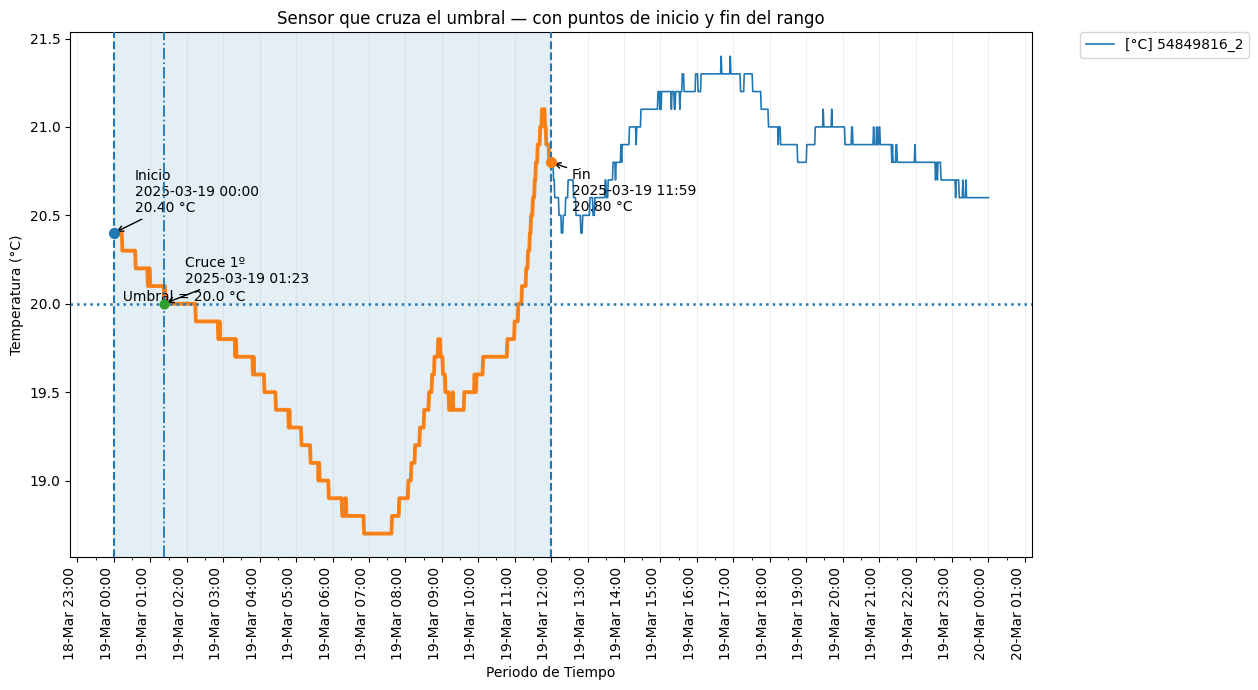

Límite superior = 20.0 °C
Rango analizado: 2025-03-19 00:00:00 → 2025-03-19 11:59:59
Sensor mostrado (cruce más temprano): [°C] 54849816_2
Hora de cruce: 2025-03-19 01:23:00
Valor en inicio/fin del rango: 20.40 °C → 20.80 °C
Tiempo FUERA de límite ([°C] 54849816_2): 2h 11m

Sensores que estuvieron FUERA de límite (ordenados por cruce):
  2025-03-19 01:23 — [°C] 54849816_2: 2h 11m
  2025-03-19 02:04 — [°C] 54853896_2: 4h 07m
  2025-03-19 02:23 — [°C] 54849888_2: 4h 38m
  2025-03-19 02:28 — [°C] 54853758_2: 3h 07m
  2025-03-19 02:40 — [°C] 54853781_2: 3h 51m
  2025-03-19 02:44 — [°C] 54699584_2: 5h 01m
  2025-03-19 02:48 — [°C] 54853838_2: 5h 42m
  2025-03-19 02:59 — [°C] 54853777_2: 4h 25m
  2025-03-19 03:04 — [°C] 54853774_2: 3h 59m
  2025-03-19 03:10 — [°C] 54853546_2: 3h 58m
  2025-03-19 03:10 — [°C] 54853783_2: 3h 56m
  2025-03-19 03:23 — [°C] 54853772_2: 4h 58m
  2025-03-19 03:39 — [°C] 54849883_2: 4h 15m
  2025-03-19 04:10 — [°C] 54853531_2: 4h 56m
  2025-03-19 04:49 — [°C] 277565

In [361]:
# ----------------- Gráfico: SOLO el sensor que cruzó primero + puntos inicio/fin -----------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# === CONFIGURA AQUÍ ===
rango_inicio = "2025-03-19 00:00:00"   # inicio del rango de análisis
rango_fin    = "2025-03-19 11:59:59"   # fin del rango de análisis

umbral = 20.0          # <-- tu límite (°C)
tipo_limite = "max"    # "max": fuera si > umbral  |  "min": fuera si < umbral

# Debes tener definidas estas dos variables antes de correr este bloque:
# - df_temp_filtered: DataFrame con columna 'Timestamp' y columnas de sensores
# - sensor_columns_temp: lista con los nombres de columnas de sensores
#   p.ej. sensor_columns_temp = [c for c in df_temp_filtered.columns if c.startswith("[°C]")]

# --- Normalización/clipeo a los datos disponibles ---
df_temp_filtered = df_temp_filtered.copy()
df_temp_filtered["Timestamp"] = pd.to_datetime(df_temp_filtered["Timestamp"], errors="coerce")
df_temp_filtered = df_temp_filtered.dropna(subset=["Timestamp"]).sort_values("Timestamp")

t_ini = pd.to_datetime(rango_inicio, errors="coerce")
t_fin = pd.to_datetime(rango_fin, errors="coerce")
if pd.isna(t_ini) or pd.isna(t_fin):
    raise ValueError("rango_inicio / rango_fin inválidos")
if t_ini > t_fin:
    t_ini, t_fin = t_fin, t_ini

tmin = df_temp_filtered["Timestamp"].min()
tmax = df_temp_filtered["Timestamp"].max()
t_ini_clip = max(t_ini, tmin)
t_fin_clip = min(t_fin, tmax)

mask_rango = (df_temp_filtered["Timestamp"] >= t_ini_clip) & (df_temp_filtered["Timestamp"] <= t_fin_clip)

# ----------------- Helpers -----------------
def _interp_at(ts, y, t_ref):
    """Interpolación lineal del valor de 'y' en el instante t_ref."""
    x = pd.to_datetime(ts).values.astype("datetime64[ns]").astype("int64")
    y = pd.to_numeric(y, errors="coerce").to_numpy(dtype=float)
    m = np.isfinite(y)
    x, y = x[m], y[m]
    if len(x) == 0:
        return np.nan
    t_ref_i64 = np.datetime64(t_ref).astype("datetime64[ns]").astype("int64")
    if t_ref_i64 <= x.min():
        return float(y[0])
    if t_ref_i64 >= x.max():
        return float(y[-1])
    j = np.searchsorted(x, t_ref_i64)
    x0, x1 = x[j-1], x[j]
    y0, y1 = y[j-1], y[j]
    if x1 == x0:
        return float(y0)
    frac = (t_ref_i64 - x0) / (x1 - x0)
    return float(y0 + frac * (y1 - y0))

def _first_cross_time(series: pd.Series, ts: pd.Series, umbral: float, tipo: str, mask=None):
    """Primera vez que cruza el umbral en la dirección indicada."""
    y = pd.to_numeric(series, errors="coerce").to_numpy(dtype=float)
    t = pd.to_datetime(ts).to_numpy()
    if mask is not None:
        mask = mask.to_numpy()
        y = y[mask]
        t = t[mask]
    if len(t) < 2:
        return None
    if tipo == "max":
        a = y[:-1] <= umbral
        b = y[ 1:] >  umbral
    else:  # "min"
        a = y[:-1] >= umbral
        b = y[ 1:] <  umbral
    idx = np.where(a & b)[0]
    if idx.size == 0:
        return None
    i = int(idx[0])
    y0, y1 = y[i], y[i+1]
    t0, t1 = pd.Timestamp(t[i]), pd.Timestamp(t[i+1])
    if np.isfinite(y0) and np.isfinite(y1) and (y1 != y0):
        frac = (umbral - y0) / (y1 - y0)
        frac = min(max(frac, 0.0), 1.0)
        return t0 + (t1 - t0) * frac
    return t0

def _tiempo_fuera(series: pd.Series, ts: pd.Series, umbral: float, tipo: str, mask=None) -> float:
    """Suma de tiempo (horas) fuera del límite (conteo por estado del extremo izquierdo del intervalo)."""
    y = pd.to_numeric(series, errors="coerce").to_numpy(dtype=float)
    t = pd.to_datetime(ts).to_numpy()
    if mask is not None:
        mask = mask.to_numpy()
        y = y[mask]
        t = t[mask]
    if len(t) < 2:
        return 0.0
    fuera = (y > umbral) if tipo == "max" else (y < umbral)
    dt_sec = np.diff(t.astype("datetime64[ns]")).astype("timedelta64[s]").astype(float)
    if dt_sec.size == 0:
        return 0.0
    fuera_left = fuera[:-1]
    total_seconds = dt_sec[fuera_left].sum()
    return float(total_seconds) / 3600.0

def fmt_hm(hours):
    """Convierte horas (float) a 'Hh MMm'."""
    if hours is None:
        return "—"
    sign = "-" if hours < 0 else ""
    total_min = int(round(abs(hours) * 60))
    h, m = divmod(total_min, 60)
    return f"{sign}{h:d}h {m:02d}m"

# ----------------- Cálculos: primer cruce y tiempos fuera -----------------
# ¿Quién cruza primero dentro del rango?
cruces = {}
for sensor in sensor_columns_temp:
    t_cross = _first_cross_time(df_temp_filtered[sensor], df_temp_filtered["Timestamp"], umbral, tipo_limite, mask_rango)
    if t_cross is not None:
        cruces[sensor] = t_cross

if cruces:
    sensor_primero = min(cruces, key=cruces.get)
    t_primera = cruces[sensor_primero]
else:
    sensor_primero = None
    t_primera = None

# Tiempo fuera del límite (en el rango) por sensor
tiempos_fuera_h = {
    sensor: _tiempo_fuera(df_temp_filtered[sensor], df_temp_filtered["Timestamp"], umbral, tipo_limite, mask_rango)
    for sensor in sensor_columns_temp
}

# ----------------- Gráfico: solo el sensor que cruzó primero + puntos inicio/fin -----------------
if t_primera is None:
    print("Ningún sensor cruza el límite en el rango seleccionado.")
else:
    sensor_sel = sensor_primero  # el que cruzó primero

    dfp = df_temp_filtered.sort_values("Timestamp")
    y_ini = _interp_at(dfp["Timestamp"], dfp[sensor_sel], t_ini_clip)
    y_fin = _interp_at(dfp["Timestamp"], dfp[sensor_sel], t_fin_clip)

    fig, ax = plt.subplots(figsize=(15, 7))
    plt.subplots_adjust(right=0.85)

    # Serie completa SOLO del sensor que cruza
    ax.plot(dfp["Timestamp"], dfp[sensor_sel], label=sensor_sel, linewidth=1.2)

    # Tramo dentro del rango, resaltado
    ax.plot(
        dfp.loc[mask_rango, "Timestamp"],
        dfp.loc[mask_rango, sensor_sel],
        linewidth=2.8, alpha=0.95, label=None, zorder=3
    )

    # Umbral y rango
    ax.axhline(umbral, linestyle=":", linewidth=1.8, zorder=4)
    ax.text(dfp["Timestamp"].iloc[0], umbral, f"  Umbral = {umbral} °C", va="bottom")
    ax.axvline(t_ini_clip, linestyle="--", linewidth=1.5, zorder=4)
    ax.axvline(t_fin_clip, linestyle="--", linewidth=1.5, zorder=4)
    ax.axvspan(t_ini_clip, t_fin_clip, alpha=0.12, zorder=1)

    # Puntos de inicio y fin del rango
    ax.scatter([t_ini_clip], [y_ini], s=50, zorder=5)
    ax.annotate(
        f"Inicio\n{t_ini_clip:%Y-%m-%d %H:%M}\n{y_ini:.2f} °C",
        xy=(t_ini_clip, y_ini), xytext=(15, 15),
        textcoords="offset points", arrowprops=dict(arrowstyle="->")
    )
    ax.scatter([t_fin_clip], [y_fin], s=50, zorder=5)
    ax.annotate(
        f"Fin\n{t_fin_clip:%Y-%m-%d %H:%M}\n{y_fin:.2f} °C",
        xy=(t_fin_clip, y_fin), xytext=(15, -35),
        ha="left", textcoords="offset points", arrowprops=dict(arrowstyle="->")
    )

    # Marcar el instante del PRIMER cruce
    y_near = dfp.loc[(dfp["Timestamp"] - t_primera).abs().idxmin(), sensor_sel]
    ax.axvline(t_primera, linestyle="-.", linewidth=1.3, zorder=5)
    ax.scatter([t_primera], [y_near], s=40, zorder=6)
    ax.annotate(
        f"Cruce 1º\n{t_primera:%Y-%m-%d %H:%M}",
        xy=(t_primera, y_near), xytext=(15, 15),
        textcoords="offset points", arrowprops=dict(arrowstyle="->")
    )

    # Formato de ejes (horas y minutos)
    ax.set_title("Sensor que cruza el umbral — con puntos de inicio y fin del rango")
    ax.set_xlabel("Periodo de Tiempo")
    ax.set_ylabel("Temperatura (°C)")
    tick_interval_h = 1  # cambia a 2, 3, 6, etc. si hay demasiados ticks
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=tick_interval_h))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%d-%b %H:%M"))
    ax.xaxis.set_minor_locator(mdates.MinuteLocator(byminute=[0, 30]))
    ax.grid(True, which="major", axis="x", alpha=0.2)

    plt.xticks(rotation=90, ha="right")
    ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.)
    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.show()

    # ----------------- Reporte en texto -----------------
    print(f"Límite {'superior' if tipo_limite=='max' else 'inferior'} = {umbral} °C")
    print(f"Rango analizado: {t_ini_clip} → {t_fin_clip}")
    print(f"Sensor mostrado (cruce más temprano): {sensor_sel}")
    print(f"Hora de cruce: {t_primera}")
    print(f"Valor en inicio/fin del rango: {y_ini:.2f} °C → {y_fin:.2f} °C")
    print(f"Tiempo FUERA de límite ({sensor_sel}): {fmt_hm(tiempos_fuera_h.get(sensor_sel, 0.0))}")

    # --------- Reporte ordenado por cruce (solo sensores con tiempo > 0) ---------
print("\nSensores que estuvieron FUERA de límite (ordenados por cruce):")

# 'cruces' ya contiene el primer cruce por sensor: {sensor: timestamp}
# Filtrar: solo los que tienen cruce y tiempo fuera > 0
tuplas = [
    (s, cruces[s], tiempos_fuera_h.get(s, 0.0))
    for s in cruces
    if tiempos_fuera_h.get(s, 0.0) > 0
]

# Ordenar por timestamp de cruce (ascendente)
tuplas.sort(key=lambda x: x[1])

if not tuplas:
    print("  Nadie estuvo fuera del límite (tiempo > 0) en el rango.")
else:
    for s, t_cross, horas in tuplas:
        # t_cross puede ser Timestamp; aseguramos formato
        try:
            stamp = f"{t_cross:%Y-%m-%d %H:%M}"
        except Exception:
            stamp = str(t_cross)
        print(f"  {stamp} — {s}: {fmt_hm(horas)}")




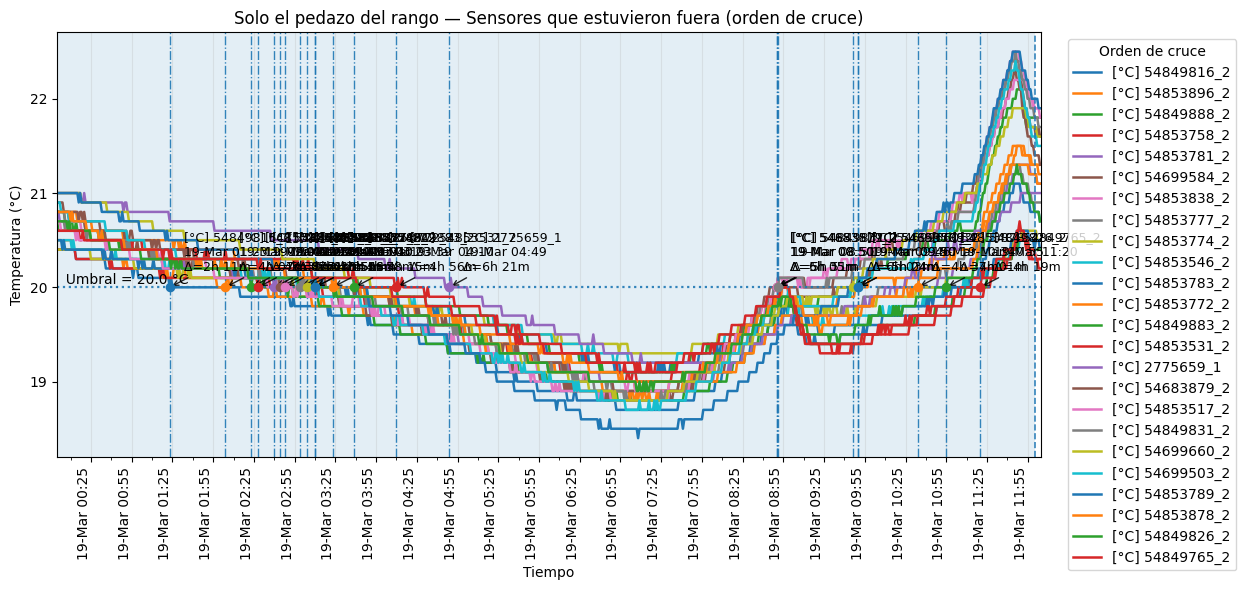

In [362]:
# ========= Gráfico adicional: SOLO EL PEDAZO DEL RANGO (sensores que sí estuvieron fuera) =========
# Construimos la lista ordenada por cruce (solo quienes tienen tiempo fuera > 0)
tuplas_zoom = [
    (s, cruces[s], tiempos_fuera_h.get(s, 0.0))
    for s in cruces
    if tiempos_fuera_h.get(s, 0.0) > 0
]
tuplas_zoom.sort(key=lambda x: x[1])  # por timestamp de cruce

if not tuplas_zoom:
    print("\n(No hay sensores con tiempo fuera > 0 para graficar solo el pedazo).")
else:
    # Sensores a trazar en el pedazo, en orden de cruce
    sensores_zoom = [s for (s, _, _) in tuplas_zoom]

    dfp = df_temp_filtered.sort_values("Timestamp").copy()
    # Ventana exactamente el rango de análisis (con un pequeño acolchonado visual)
    pad_min = pd.Timedelta(minutes=5)
    t0z = max(t_ini_clip - pad_min, dfp["Timestamp"].min())
    t1z = min(t_fin_clip + pad_min, dfp["Timestamp"].max())
    maskz = (dfp["Timestamp"] >= t0z) & (dfp["Timestamp"] <= t1z)

    fig, ax = plt.subplots(figsize=(15, 6))

    # Trazar SOLO el pedazo del rango, por sensor, en orden de cruce
    for s in sensores_zoom:
        y = pd.to_numeric(dfp.loc[maskz, s], errors="coerce")
        ax.plot(dfp.loc[maskz, "Timestamp"], y, label=s, linewidth=1.8)

        # Marcar su cruce si cae dentro del tramo
        tcr = cruces[s]
        if t0z <= tcr <= t1z:
            y_near = dfp.loc[(dfp["Timestamp"] - tcr).abs().idxmin(), s]
            ax.scatter([tcr], [y_near], s=35, zorder=5)
            ax.axvline(tcr, linestyle="-.", linewidth=1.0, alpha=0.9)
            ax.annotate(
                f"{s}\n{tcr:%d-%b %H:%M}\nΔ={fmt_hm(tiempos_fuera_h.get(s,0))}",
                xy=(tcr, y_near), xytext=(10, 12),
                textcoords="offset points",
                arrowprops=dict(arrowstyle="->", alpha=0.85),
                fontsize=9
            )

    # Umbral y sombreado del rango analizado
    ax.axhline(umbral, linestyle=":", linewidth=1.6, alpha=0.9)
    ax.text(dfp["Timestamp"].iloc[0], umbral, f"  Umbral = {umbral} °C", va="bottom")
    ax.axvline(t_ini_clip, linestyle="--", linewidth=1.2, alpha=0.9)
    ax.axvline(t_fin_clip, linestyle="--", linewidth=1.2, alpha=0.9)
    ax.axvspan(t_ini_clip, t_fin_clip, alpha=0.12, zorder=0)

    # Formato de eje X (horas:min) con paso razonable
    dur_min = max(1, int(round((t1z - t0z).total_seconds() / 60)))
    if   dur_min <= 60:  step = 5
    elif dur_min <= 180: step = 10
    elif dur_min <= 360: step = 15
    else:                 step = 30
    ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=step))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b %H:%M'))
    ax.xaxis.set_minor_locator(mdates.MinuteLocator(interval=max(1, step//2)))
    ax.grid(True, which="major", axis="x", alpha=0.25)

    ax.set_xlim(t0z, t1z)
    ax.set_title("Solo el pedazo del rango — Sensores que estuvieron fuera (orden de cruce)")
    ax.set_xlabel("Tiempo")
    ax.set_ylabel("Temperatura (°C)")
    plt.xticks(rotation=90, ha="right")
    ax.legend(title="Orden de cruce", bbox_to_anchor=(1.02, 1), loc="upper left")
    plt.tight_layout(rect=[0, 0, 0.84, 1])
    plt.show()


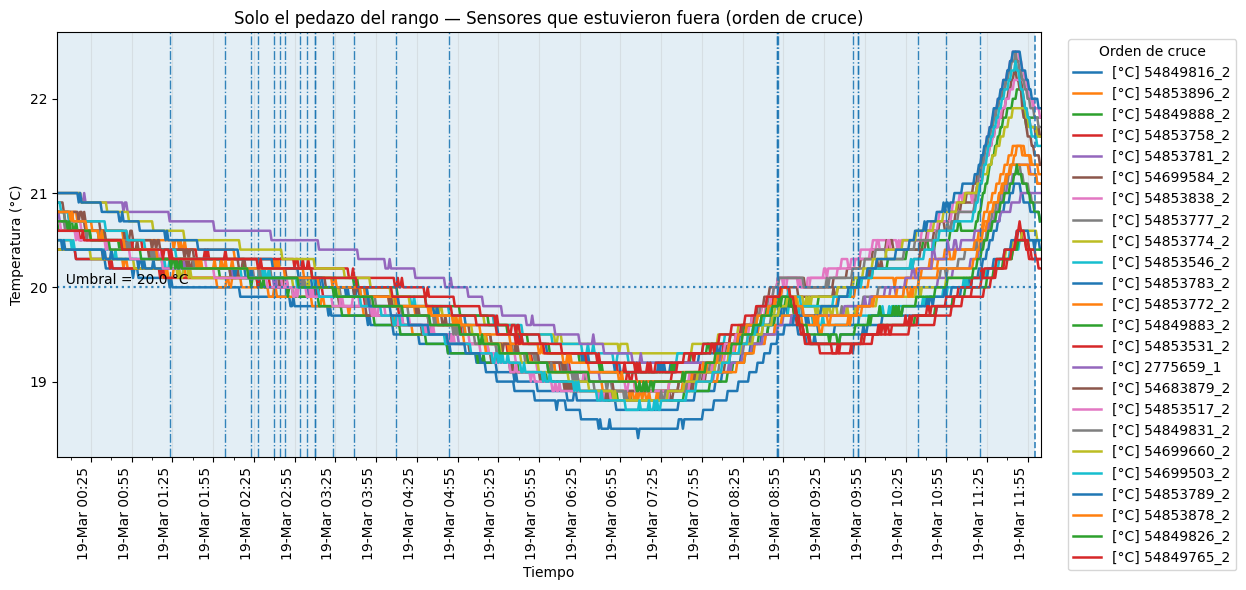

In [363]:
# ========= Gráfico adicional: SOLO EL PEDAZO DEL RANGO (sensores que sí estuvieron fuera) =========
SHOW_MARKERS = False   # <- no dibuja puntos ni anotaciones
SHOW_VLINES  = True    # <- sí dibuja líneas verticales en el instante de cruce

# Construimos la lista ordenada por cruce (solo quienes tienen tiempo fuera > 0)
tuplas_zoom = [
    (s, cruces[s], tiempos_fuera_h.get(s, 0.0))
    for s in cruces
    if tiempos_fuera_h.get(s, 0.0) > 0
]
tuplas_zoom.sort(key=lambda x: x[1])  # por timestamp de cruce

if not tuplas_zoom:
    print("\n(No hay sensores con tiempo fuera > 0 para graficar solo el pedazo).")
else:
    # Sensores a trazar en el pedazo, en orden de cruce
    sensores_zoom = [s for (s, _, _) in tuplas_zoom]

    dfp = df_temp_filtered.sort_values("Timestamp").copy()
    # Ventana exactamente el rango de análisis (con un pequeño acolchonado visual)
    pad_min = pd.Timedelta(minutes=5)
    t0z = max(t_ini_clip - pad_min, dfp["Timestamp"].min())
    t1z = min(t_fin_clip + pad_min, dfp["Timestamp"].max())
    maskz = (dfp["Timestamp"] >= t0z) & (dfp["Timestamp"] <= t1z)

    fig, ax = plt.subplots(figsize=(15, 6))

    # Trazar SOLO el pedazo del rango, por sensor, en orden de cruce
    for s in sensores_zoom:
        y = pd.to_numeric(dfp.loc[maskz, s], errors="coerce")
        ax.plot(dfp.loc[maskz, "Timestamp"], y, label=s, linewidth=1.8)

        # Marcar su cruce (solo con línea vertical si SHOW_VLINES)
        tcr = cruces[s]
        if SHOW_VLINES and (t0z <= tcr <= t1z):
            ax.axvline(tcr, linestyle="-.", linewidth=1.0, alpha=0.9)
        # (sin puntos ni anotaciones)

    # Umbral y sombreado del rango analizado
    ax.axhline(umbral, linestyle=":", linewidth=1.6, alpha=0.9)
    ax.text(dfp["Timestamp"].iloc[0], umbral, f"  Umbral = {umbral} °C", va="bottom")
    ax.axvline(t_ini_clip, linestyle="--", linewidth=1.2, alpha=0.9)
    ax.axvline(t_fin_clip, linestyle="--", linewidth=1.2, alpha=0.9)
    ax.axvspan(t_ini_clip, t_fin_clip, alpha=0.12, zorder=0)

    # Formato de eje X (horas:min) con paso razonable
    dur_min = max(1, int(round((t1z - t0z).total_seconds() / 60)))
    if   dur_min <= 60:  step = 5
    elif dur_min <= 180: step = 10
    elif dur_min <= 360: step = 15
    else:                 step = 30
    ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=step))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b %H:%M'))
    ax.xaxis.set_minor_locator(mdates.MinuteLocator(interval=max(1, step//2)))
    ax.grid(True, which="major", axis="x", alpha=0.25)

    ax.set_xlim(t0z, t1z)
    ax.set_title("Solo el pedazo del rango — Sensores que estuvieron fuera (orden de cruce)")
    ax.set_xlabel("Tiempo")
    ax.set_ylabel("Temperatura (°C)")
    plt.xticks(rotation=90, ha="right")
    ax.legend(title="Orden de cruce", bbox_to_anchor=(1.02, 1), loc="upper left")
    plt.tight_layout(rect=[0, 0, 0.84, 1])
    plt.show()



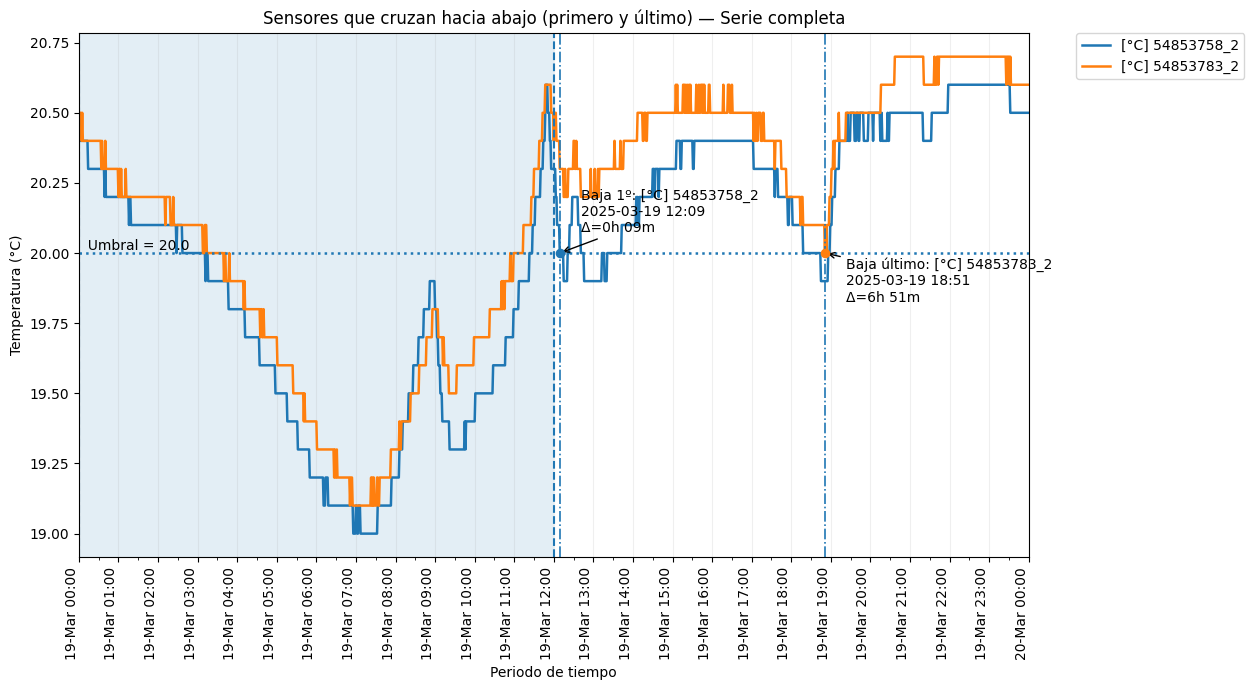

Umbral: 20.0 °C  |  Referencia: después de 2025-03-19 11:59:59
Primero en regresar:  [°C] 54853758_2 a las 2025-03-19 12:09 (Δ=0h 09m)
Último en regresar:   [°C] 54853783_2  a las 2025-03-19 18:51 (Δ=6h 51m)

Orden de regreso (más temprano → más tarde):
  2025-03-19 12:09 — [°C] 54853758_2: Δ=0h 09m
  2025-03-19 12:17 — [°C] 54849765_2: Δ=0h 17m
  2025-03-19 18:51 — [°C] 54853783_2: Δ=6h 51m


In [364]:
# === Cruces hacia ABAJO después del límite y gráfico con horas:min ===
# Referencia de tiempo: después del límite final del rango
t_ref = t_fin_clip

# Helper: primera vez que cruza HACIA ABAJO (> umbral -> <= umbral) después de t_ref
def _first_cross_down_after(series: pd.Series, ts: pd.Series, umbral: float, t_ref: pd.Timestamp):
    y = pd.to_numeric(series, errors="coerce").to_numpy(dtype=float)
    t = pd.to_datetime(ts).to_numpy()
    n = len(t)
    if n < 2:
        return None
    idx0 = int(np.searchsorted(t, np.datetime64(t_ref), side="left"))
    i_start = max(0, idx0 - 1)
    for i in range(i_start, n - 1):
        y0, y1 = y[i], y[i+1]
        t0, t1 = pd.Timestamp(t[i]), pd.Timestamp(t[i+1])
        if not (np.isfinite(y0) and np.isfinite(y1)):
            continue
        if (y0 > umbral) and (y1 <= umbral):  # cruce hacia abajo
            if y1 != y0:
                frac = (umbral - y0) / (y1 - y0)
                frac = min(max(frac, 0.0), 1.0)
                t_cross = t0 + (t1 - t0) * frac
            else:
                t_cross = t0
            if t_cross >= t_ref:
                return t_cross
    return None

# Helper: formato horas -> "Hh MMm"
def fmt_hm(hours):
    if hours is None:
        return "—"
    sign = "-" if hours < 0 else ""
    total_min = int(round(abs(hours) * 60))
    h, m = divmod(total_min, 60)
    return f"{sign}{h:d}h {m:02d}m"

# Calcular cruces y retardos (Δ desde t_ref)
cruces_down_after = {}
retardos_horas = {}
for s in sensor_columns_temp:
    t_cross = _first_cross_down_after(df_temp_filtered[s], df_temp_filtered["Timestamp"], umbral, t_ref)
    if t_cross is not None:
        cruces_down_after[s] = t_cross
        retardos_horas[s] = (t_cross - t_ref).total_seconds() / 3600.0

sensor_down_primero = sensor_down_ultimo = None
t_down_primero = t_down_ultimo = None
if cruces_down_after:
    sensor_down_primero = min(cruces_down_after, key=cruces_down_after.get)
    sensor_down_ultimo  = max(cruces_down_after, key=cruces_down_after.get)
    t_down_primero = cruces_down_after[sensor_down_primero]
    t_down_ultimo  = cruces_down_after[sensor_down_ultimo]

# === Mostrar SOLO los sensores primero y último en TODO el periodo ===
sensores_a_mostrar = []
if sensor_down_primero is not None:
    sensores_a_mostrar.append(sensor_down_primero)
if (sensor_down_ultimo is not None) and (sensor_down_ultimo != sensor_down_primero):
    sensores_a_mostrar.append(sensor_down_ultimo)

if not sensores_a_mostrar:
    print("No hay sensores que crucen hacia abajo después del límite de tiempo.")
else:
    fig, ax = plt.subplots(figsize=(15, 7))
    dfp = df_temp_filtered.sort_values("Timestamp")
    xmin, xmax = dfp["Timestamp"].min(), dfp["Timestamp"].max()

    # Trazar SOLO esos sensores
    for s in sensores_a_mostrar:
        ax.plot(dfp["Timestamp"], dfp[s], label=s, linewidth=1.8)

    # Línea horizontal del umbral
    ax.axhline(umbral, linestyle=":", linewidth=1.8)
    ax.text(xmin, umbral, f"  Umbral = {umbral}", va="bottom")

    # Rango de interés
    ax.axvline(t_ini_clip, linestyle="--", linewidth=1.5)
    ax.axvline(t_fin_clip, linestyle="--", linewidth=1.5)
    ax.axvspan(t_ini_clip, t_fin_clip, alpha=0.12, zorder=0)

    # Marcar y anotar el primer cruce
    if t_down_primero is not None:
        y_near1 = dfp.loc[(dfp["Timestamp"] - t_down_primero).abs().idxmin(), sensor_down_primero]
        ax.scatter([t_down_primero], [y_near1], s=35, zorder=5)
        ax.axvline(t_down_primero, linestyle="-.", linewidth=1.2)
        ax.annotate(
            f"Baja 1º: {sensor_down_primero}\n{t_down_primero:%Y-%m-%d %H:%M}\nΔ={fmt_hm(retardos_horas[sensor_down_primero])}",
            xy=(t_down_primero, y_near1), xytext=(15, 15),
            textcoords="offset points", arrowprops=dict(arrowstyle="->")
        )

    # Marcar y anotar el último cruce (si distinto)
    if (t_down_ultimo is not None) and (t_down_ultimo != t_down_primero):
        y_near2 = dfp.loc[(dfp["Timestamp"] - t_down_ultimo).abs().idxmin(), sensor_down_ultimo]
        ax.scatter([t_down_ultimo], [y_near2], s=35, zorder=5)
        ax.axvline(t_down_ultimo, linestyle="-.", linewidth=1.2)
        ax.annotate(
            f"Baja último: {sensor_down_ultimo}\n{t_down_ultimo:%Y-%m-%d %H:%M}\nΔ={fmt_hm(retardos_horas[sensor_down_ultimo])}",
            xy=(t_down_ultimo, y_near2), xytext=(15, -35),
            ha="left", textcoords="offset points", arrowprops=dict(arrowstyle="->")
        )

    # Formato de ejes: HORAS y MINUTOS (igual estilo)
    tick_interval_h = 1  # ajusta a 2, 3, 6 si hay muchos ticks
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=tick_interval_h))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b %H:%M'))
    ax.xaxis.set_minor_locator(mdates.MinuteLocator(byminute=[0, 30]))
    ax.grid(True, which='major', axis='x', alpha=0.2)

    ax.set_xlim(xmin, xmax)
    ax.set_title("Sensores que cruzan hacia abajo (primero y último) — Serie completa")
    ax.set_xlabel("Periodo de tiempo")
    ax.set_ylabel("Temperatura (°C)")
    plt.xticks(rotation=90, ha="right")
    ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.)
    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.show()

    # ====== REPORTE — orden de regreso (cruce hacia abajo) ======
print(f"Umbral: {umbral} °C  |  Referencia: después de {t_ref}")

# Construir lista (sensor, t_cruce, retardo_h) y filtrar retardo > 0
tuplas = [
    (s, cruces_down_after[s], retardos_horas[s])
    for s in cruces_down_after
    if retardos_horas.get(s, 0.0) > 0
]

# Ordenar por instante de cruce (más temprano → más tarde)
tuplas.sort(key=lambda x: x[1])

if not tuplas:
    print("Ningún sensor regresó (cruzó hacia abajo) con retardo > 0 después del límite.")
else:
    # Resumen primero/último
    s_first, t_first, d_first = tuplas[0]
    s_last,  t_last,  d_last  = tuplas[-1]

    print(f"Primero en regresar:  {s_first} a las {t_first:%Y-%m-%d %H:%M} (Δ={fmt_hm(d_first)})")
    print(f"Último en regresar:   {s_last}  a las {t_last:%Y-%m-%d %H:%M} (Δ={fmt_hm(d_last)})")

    print("\nOrden de regreso (más temprano → más tarde):")
    for s, t_cross, delay in tuplas:
        print(f"  {t_cross:%Y-%m-%d %H:%M} — {s}: Δ={fmt_hm(delay)}")




##Generacio de Reporte Prueba

In [365]:


# ====================================================================================
# REPORTE DE TEMPERATURA (PERIODO DE LA GRÁFICA)
# ====================================================================================
import numpy as np
import pandas as pd

# ----------------- Helpers de fechas en español (abreviado) -----------------
_MESES_ES_ABR = ["ene","feb","mar","abr","may","jun","jul","ago","sep","oct","nov","dic"]

def fecha_es(dt: pd.Timestamp) -> str:
    if dt is None or pd.isna(dt):
        return ""
    return f"{dt.day:02d}/{_MESES_ES_ABR[dt.month-1]}/{dt.year}"

def fecha_hora_es(dt: pd.Timestamp) -> str:
    if dt is None or pd.isna(dt):
        return ""
    return f"{fecha_es(dt)} {dt.strftime('%H:%M:%S')}"

# ---- Compactador genérico de rachas (sin warnings) ----
def compactar_eventos_contiguos(df_eventos,
                                column_name,          # p.ej. "temperatura" o "humedad"
                                step="1min",          # "infer" o "1min","5min",...
                                formato_fecha_in="%d/%m/%Y",
                                formato_hora_in="%H:%M:%S"):
    cols_out = ["fecha_inicio","hora_inicio","fecha_fin","hora_fin",column_name,"n_registros"]
    if df_eventos is None or df_eventos.empty:
        return pd.DataFrame(columns=cols_out)

    s = df_eventos["fecha"].astype(str).str.strip() + " " + df_eventos["hora"].astype(str).str.strip()
    dt = pd.to_datetime(s, format=f"{formato_fecha_in} {formato_hora_in}", errors="coerce")

    m = dt.notna()
    if not m.any():
        return pd.DataFrame(columns=cols_out)

    df = df_eventos.loc[m].copy()
    df["_dt"] = dt[m]
    df.sort_values("_dt", inplace=True)

    if step == "infer":
        diffs = df["_dt"].diff().dropna()
        expected = (diffs.mode().iloc[0] if not diffs.empty else pd.Timedelta(minutes=1))
    else:
        expected = pd.Timedelta(step)

    grp = (df["_dt"].diff() != expected).cumsum()

    out = df.groupby(grp).agg(
        dt_ini=("_dt","first"),
        dt_fin=("_dt","last"),
        **{column_name: (column_name,"first")},
        n_registros=("hora","size")
    ).reset_index(drop=True)

    out["fecha_inicio"] = out["dt_ini"].apply(fecha_es)
    out["hora_inicio"]  = out["dt_ini"].dt.strftime("%H:%M:%S")
    out["fecha_fin"]    = out["dt_fin"].apply(fecha_es)
    out["hora_fin"]     = out["dt_fin"].dt.strftime("%H:%M:%S")

    return out[["fecha_inicio","hora_inicio","fecha_fin","hora_fin",column_name,"n_registros"]]

# ---- Reporte principal (usa EXACTAMENTE el periodo de la gráfica) ----
def resumen_temperaturas_periodo(
    df,                                # Debe tener 'Timestamp' y columnas [°C]*
    t_ini_clip: pd.Timestamp,
    t_fin_clip: pd.Timestamp,
    sensor_columns_temp=None,          # lista; si None, autodetecta por prefijo "[°C]"
    decimales_empate=2,
    tolerancia=None,
    Ea_kJ=83.144
):
    def safe_round(x, ndigits=None):
        if x is None: return None
        try:
            if isinstance(x, float) and np.isnan(x): return None
        except Exception:
            pass
        return round(x, ndigits) if ndigits is not None else round(x)

    # --- Normaliza y recorta al periodo ---
    df = df.copy()
    df["Timestamp"] = pd.to_datetime(df["Timestamp"], errors="coerce")
    df = df.dropna(subset=["Timestamp"]).sort_values("Timestamp")
    mask = (df["Timestamp"] >= t_ini_clip) & (df["Timestamp"] <= t_fin_clip)
    df = df.loc[mask].copy()

    # --- Columnas de temperatura ---
    if sensor_columns_temp is None:
        sensor_columns_temp = [c for c in df.columns if str(c).strip().startswith("[°C]")]
    temp_cols = list(sensor_columns_temp)

    ts = df["Timestamp"]
    temps_num = df[temp_cols].apply(pd.to_numeric, errors="coerce") if temp_cols else pd.DataFrame()

    fecha_inicio = ts.min() if ts.notna().any() else None
    fecha_final  = ts.max() if ts.notna().any() else None
    tiempo_total_td = (fecha_final - fecha_inicio) if (fecha_inicio is not None and fecha_final is not None) else None
    tiempo_total_horas = (tiempo_total_td.total_seconds()/3600) if tiempo_total_td is not None else None

    promedio_general = float(temps_num.stack().mean()) if not temps_num.empty else None

    # --- Promedios por sensor (empates) ---
    sensores_prom_max = []; sensores_prom_min = []
    promedio_sensor_prom_max = promedio_sensor_prom_min = None
    if not temps_num.empty:
        medias = temps_num.mean(axis=0, skipna=True).dropna()
        if not medias.empty:
            if tolerancia is None:
                mr = medias.round(decimales_empate)
                max_r = float(mr.max()); min_r = float(mr.min())
                sensores_prom_max = mr.index[mr.eq(max_r)].tolist(); promedio_sensor_prom_max = max_r
                sensores_prom_min = mr.index[mr.eq(min_r)].tolist(); promedio_sensor_prom_min = min_r
            else:
                mx = float(medias.max()); mn = float(medias.min())
                sensores_prom_max = medias.index[np.isclose(medias, mx, atol=tolerancia)].tolist(); promedio_sensor_prom_max = mx
                sensores_prom_min = medias.index[np.isclose(medias, mn, atol=tolerancia)].tolist(); promedio_sensor_prom_min = mn

    # --- Tablas de máximos/mínimos (dentro del periodo) ---
    def _event_df(mask_df, valor, column_name):
        cols = ["fecha","hora",column_name,"n_sensores","sensores"]
        if ts is None or mask_df.empty: return pd.DataFrame(columns=cols)
        rows = mask_df.any(axis=1)
        if not rows.any(): return pd.DataFrame(columns=cols)
        ts_sel = ts.loc[rows]
        n_sen  = mask_df.loc[rows].sum(axis=1).astype(int)
        sensores = mask_df.loc[rows].apply(lambda r: r.index[r].tolist(), axis=1)
        out = pd.DataFrame({
            "fecha": ts_sel.dt.strftime("%d/%m/%Y").values,
            "hora":  ts_sel.dt.strftime("%H:%M:%S").values,
            column_name: valor,
            "n_sensores": n_sen.values,
            "sensores": sensores.values
        })
        return out.reset_index(drop=True)

    if not temps_num.empty:
        temp_max = float(temps_num.max().max()); mask_max = temps_num.eq(temp_max); df_max = _event_df(mask_max, temp_max, "temperatura")
        temp_min = float(temps_num.min().min()); mask_min = temps_num.eq(temp_min); df_min = _event_df(mask_min, temp_min, "temperatura")
        repeticiones_max = int(mask_max.sum().sum()); repeticiones_min = int(mask_min.sum().sum())
    else:
        temp_max = temp_min = None; repeticiones_max = repeticiones_min = 0
        df_max = pd.DataFrame(columns=["fecha","hora","temperatura","n_sensores","sensores"])
        df_min = pd.DataFrame(columns=["fecha","hora","temperatura","n_sensores","sensores"])

    # --- Dif. máxima instantánea por fila ---
    def _diff_max_instantanea(X):
        if X.empty: return None
        valid = X.notna().sum(axis=1) >= 2
        if not valid.any(): return None
        rng = (X.max(axis=1, skipna=True) - X.min(axis=1, skipna=True))[valid]
        if rng.empty: return None
        return float(rng.max())
    dif_max_inst = safe_round(_diff_max_instantanea(temps_num), 1)

    # --- MKT por sensor ---
    sensores_mkt_max = []; sensores_mkt_min = []; mkt_max_val = mkt_min_val = None
    if not temps_num.empty:
        R_kJ = 0.008314462618
        Ea_over_R = Ea_kJ / R_kJ
        def mkt_col(s):
            vals = pd.to_numeric(s, errors="coerce").to_numpy(dtype=float)
            vals = vals[np.isfinite(vals)]
            if vals.size == 0: return np.nan
            TK = vals + 273.15
            m = np.exp(-Ea_over_R / TK).mean()
            if not np.isfinite(m) or m <= 0: return np.nan
            TK_mkt = Ea_over_R / (-np.log(m))
            return TK_mkt - 273.15
        mkt_series = pd.Series({c: mkt_col(df[c]) for c in temp_cols}).dropna()
        if not mkt_series.empty:
            if tolerancia is None:
                mr = mkt_series.round(decimales_empate)
                mkt_max_val = float(mr.max()); sensores_mkt_max = mr.index[mr.eq(mkt_max_val)].tolist()
                mkt_min_val = float(mr.min()); sensores_mkt_min = mr.index[mr.eq(mkt_min_val)].tolist()
            else:
                mx = float(mkt_series.max()); mn = float(mkt_series.min())
                mkt_max_val = mx; mkt_min_val = mn
                sensores_mkt_max = mkt_series.index[np.isclose(mkt_series, mx, atol=tolerancia)].tolist()
                sensores_mkt_min = mkt_series.index[np.isclose(mkt_series, mn, atol=tolerancia)].tolist()

    # --- Resumen (mismo formato que tu versión) ---
    resumen_temp = {
        "Parametro                        Resultado"
        "\n------------------------------------------------": "",
        "\nfecha_hora_inicio              ": fecha_hora_es(fecha_inicio),
        "\nfecha_hora_final.              ": fecha_hora_es(fecha_final),
        "\ntiempo_total_horas.            ": safe_round(tiempo_total_horas, 1),
        "\ncantidad de sensores utilizados": len(temp_cols),
        "\ntemperatura promedio.          ": safe_round(promedio_general, 1),
        "\ntemperatura_maxima.            ": temp_max,
        "\nrepeticiones_temperatura_maxima": repeticiones_max,
        "\ntemperatura_minima.            ": temp_min,
        "\nrepeticiones_temperatura_minima": repeticiones_min,
        "\ndiferencia_maxima_instantanea. ": dif_max_inst,
        "\ntemperatura_promedio_maxima.   ": safe_round(promedio_sensor_prom_max, 1),
        "\nsensores_promedio_maximo.      ": sensores_prom_max,
        "\ntemperatura_promedio_minima.   ": safe_round(promedio_sensor_prom_min, 1),
        "\nsensores_promedio_minimo.      ": sensores_prom_min,
        "\nmkt maximo.                    ": safe_round(mkt_max_val, 1),
        "\nsensores_mkt_maximo.           ": sensores_mkt_max,
        "\nmkt_minimo.                    ": safe_round(mkt_min_val, 1),
        "\nsensores_mkt_minimo.           ": sensores_mkt_min,
    }
    return resumen_temp, temp_cols, df_max, df_min


# ====================================================================================
# REPORTE DE HUMEDAD (PERIODO DE LA GRÁFICA)
# ====================================================================================
# Helpers con meses largos (como tu versión de humedad)
_MESES_ES_LARGO = ["enero","febrero","marzo","abril","mayo","junio","julio","agosto",
                   "septiembre","octubre","noviembre","diciembre"]

def fecha_es_largo(dt: pd.Timestamp) -> str:
    if dt is None or pd.isna(dt): return ""
    return f"{dt.day:02d} de {_MESES_ES_LARGO[dt.month-1]} de {dt.year}"

def fecha_hora_es_largo(dt: pd.Timestamp) -> str:
    if dt is None or pd.isna(dt): return ""
    return f"{fecha_es_largo(dt)} {dt.strftime('%H:%M:%S')}"

def resumen_humedad_periodo(
    df,                                # Debe tener 'Timestamp' y columnas [%Hr]*
    t_ini_clip: pd.Timestamp,
    t_fin_clip: pd.Timestamp,
    sensor_columns_hum=None,           # lista; si None, autodetecta por prefijo "[%Hr]"
    decimales_empate=2,
    tolerancia=None
):
    def safe_round(x, ndigits=None):
        if x is None: return None
        try:
            if isinstance(x, float) and np.isnan(x): return None
        except Exception:
            pass
        return round(x, ndigits) if ndigits is not None else round(x)

    # Recorte al periodo
    df = df.copy()
    df["Timestamp"] = pd.to_datetime(df["Timestamp"], errors="coerce")
    df = df.dropna(subset=["Timestamp"]).sort_values("Timestamp")
    mask = (df["Timestamp"] >= t_ini_clip) & (df["Timestamp"] <= t_fin_clip)
    df = df.loc[mask].copy()

    # Columnas de humedad
    if sensor_columns_hum is None:
        sensor_columns_hum = [c for c in df.columns if str(c).strip().lower().startswith("[%hr]")]
    hum_cols = list(sensor_columns_hum)

    ts = df["Timestamp"]
    hum_num = df[hum_cols].apply(pd.to_numeric, errors="coerce") if hum_cols else pd.DataFrame()

    fecha_inicio = ts.min() if ts.notna().any() else None
    fecha_final  = ts.max() if ts.notna().any() else None
    tiempo_total_td = (fecha_final - fecha_inicio) if (fecha_inicio is not None and fecha_final is not None) else None
    tiempo_total_horas = (tiempo_total_td.total_seconds()/3600) if tiempo_total_td is not None else None

    promedio_general = float(hum_num.stack().mean()) if not hum_num.empty else None

    # Promedios
    sensores_prom_max = []; sensores_prom_min = []
    promedio_sensor_prom_max = promedio_sensor_prom_min = None
    if not hum_num.empty:
        medias = hum_num.mean(axis=0, skipna=True).dropna()
        if not medias.empty:
            if tolerancia is None:
                mr = medias.round(decimales_empate)
                max_r = float(mr.max()); min_r = float(mr.min())
                sensores_prom_max = mr.index[mr.eq(max_r)].tolist(); promedio_sensor_prom_max = max_r
                sensores_prom_min = mr.index[mr.eq(min_r)].tolist(); promedio_sensor_prom_min = min_r
            else:
                mx = float(medias.max()); mn = float(medias.min())
                sensores_prom_max = medias.index[np.isclose(medias, mx, atol=tolerancia)].tolist(); promedio_sensor_prom_max = mx
                sensores_prom_min = medias.index[np.isclose(medias, mn, atol=tolerancia)].tolist(); promedio_sensor_prom_min = mn

    # Eventos max/min
    def _event_df(mask_df, valor, column_name):
        cols = ["fecha","hora",column_name,"n_sensores","sensores"]
        if ts is None or mask_df.empty: return pd.DataFrame(columns=cols)
        rows = mask_df.any(axis=1)
        if not rows.any(): return pd.DataFrame(columns=cols)
        ts_sel = ts.loc[rows]
        n_sen  = mask_df.loc[rows].sum(axis=1).astype(int)
        sensores = mask_df.loc[rows].apply(lambda r: r.index[r].tolist(), axis=1)
        out = pd.DataFrame({
            "fecha": ts_sel.dt.strftime("%d/%m/%Y").values,
            "hora":  ts_sel.dt.strftime("%H:%M:%S").values,
            column_name: valor,
            "n_sensores": n_sen.values,
            "sensores": sensores.values
        })
        return out.reset_index(drop=True)

    if not hum_num.empty:
        h_max = float(hum_num.max().max()); mask_max = hum_num.eq(h_max); df_max = _event_df(mask_max, h_max, "humedad")
        h_min = float(hum_num.min().min()); mask_min = hum_num.eq(h_min); df_min = _event_df(mask_min, h_min, "humedad")
        repeticiones_max = int(mask_max.sum().sum()); repeticiones_min = int(mask_min.sum().sum())
    else:
        h_max = h_min = None; repeticiones_max = repeticiones_min = 0
        df_max = pd.DataFrame(columns=["fecha","hora","humedad","n_sensores","sensores"])
        df_min = pd.DataFrame(columns=["fecha","hora","humedad","n_sensores","sensores"])

    # Diferencia máxima instantánea
    def _diff_max_instantanea(X):
        if X.empty: return None
        valid = X.notna().sum(axis=1) >= 2
        if not valid.any(): return None
        rng = (X.max(axis=1, skipna=True) - X.min(axis=1, skipna=True))[valid]
        if rng.empty: return None
        return float(rng.max())
    dif_max_inst = safe_round(_diff_max_instantanea(hum_num), 1)

    # Resumen con el MISMO formato que tu versión de humedad
    resumen_hum = {
        "\nhumedad promedio.              ": safe_round(promedio_general, 1),
        "\nhumedad_maxima.                ": h_max,
        "\nrepeticiones_humedad_maxima.   ": repeticiones_max,
        "\nhumedad_minima.                ": h_min,
        "\nrepeticiones_humedad_minima.   ": repeticiones_min,
        "\ndiferencia_maxima_instantanea. ": dif_max_inst,
        "\nhumedad_promedio_maxima.       ": safe_round(promedio_sensor_prom_max, 1),
        "\nsensores_promedio_maximo.      ": sensores_prom_max,
        "\nhumedad_promedio_minima.       ": safe_round(promedio_sensor_prom_min, 1),
        "\nsensores_promedio_minimo.      ": sensores_prom_min,
    }
    return resumen_hum, hum_cols, df_max, df_min


##Reporte prueba

In [366]:
# TEMPERATURA (periodo ya recortado por t_ini_clip / t_fin_clip)
resumen_temp, cols_temp, df_tmax, df_tmin = resumen_temperaturas_periodo(
    df=df_temp,
    t_ini_clip=t_ini_clip,
    t_fin_clip=t_fin_clip,
    sensor_columns_temp=sensor_columns_temp,   # o None para autodetectar
    decimales_empate=1,
    tolerancia=None,
    Ea_kJ=83.144
)

# HUMEDAD
resumen_hum, cols_hum, df_hmax, df_hmin = resumen_humedad_periodo(
    df=df_humidity,
    t_ini_clip=t_ini_clip,
    t_fin_clip=t_fin_clip,
    sensor_columns_hum=sensor_columns_humidity,     # o None para autodetectar
    decimales_empate=1,
    tolerancia=None
)

# Compactar rachas (si quieres agrupar continuidades)
df_tmax_comp = compactar_eventos_contiguos(df_tmax, column_name="temperatura",
                                           step="1min", formato_fecha_in="%d/%m/%Y", formato_hora_in="%H:%M:%S")
df_tmin_comp = compactar_eventos_contiguos(df_tmin, column_name="temperatura",
                                           step="1min", formato_fecha_in="%d/%m/%Y", formato_hora_in="%H:%M:%S")

df_hmax_comp = compactar_eventos_contiguos(df_hmax, column_name="humedad",
                                           step="1min", formato_fecha_in="%d/%m/%Y", formato_hora_in="%H:%M:%S")
df_hmin_comp = compactar_eventos_contiguos(df_hmin, column_name="humedad",
                                           step="1min", formato_fecha_in="%d/%m/%Y", formato_hora_in="%H:%M:%S")

# Impresión
print("=== RESUMEN TEMPERATURA ===")
for k, v in resumen_temp.items():
    print(f"{k}: {v}")

print("\n=== RESUMEN HUMEDAD ===")
for k, v in resumen_hum.items():
    print(f"{k}: {v}")

print("\nTemp — Máximos (compactado):"); print(df_tmax_comp)
print("\nTemp — Mínimos (compactado):"); print(df_tmin_comp)
print("\nHumedad — Máximos (compactado):"); print(df_hmax_comp)
print("\nHumedad — Mínimos (compactado):"); print(df_hmin_comp)



=== RESUMEN TEMPERATURA ===
Parametro                        Resultado
------------------------------------------------: 

fecha_hora_inicio              : 19/mar/2025 00:00:00

fecha_hora_final.              : 19/mar/2025 11:59:00

tiempo_total_horas.            : 12.0

cantidad de sensores utilizados: 24

temperatura promedio.          : 19.9

temperatura_maxima.            : 22.5

repeticiones_temperatura_maxima: 12

temperatura_minima.            : 18.4

repeticiones_temperatura_minima: 1

diferencia_maxima_instantanea. : 2.1

temperatura_promedio_maxima.   : 20.1

sensores_promedio_maximo.      : ['[°C] 2775659_1']

temperatura_promedio_minima.   : 19.6

sensores_promedio_minimo.      : ['[°C] 54849816_2']

mkt maximo.                    : 20.1

sensores_mkt_maximo.           : ['[°C] 2775659_1', '[°C] 54683879_2', '[°C] 54699660_2']

mkt_minimo.                    : 19.6

sensores_mkt_minimo.           : ['[°C] 54849816_2']

=== RESUMEN HUMEDAD ===

humedad promedio.             

##Mapeo prueba

In [367]:
#===================== MAPEO =====================

# --------- helpers de IDs / niveles / ubicación ----------
def id_solo(colname: str) -> str:
    m = re.search(r"(\d+)", str(colname))
    return m.group(1) if m else str(colname).strip()

def nivel_de(sensor_id: str, level_override: dict) -> int | None:
    sid = id_solo(sensor_id)
    return int(level_override.get(sid)) if sid in level_override else None

def ubicacion_text(nivel: int | None, level_meters: dict) -> str:
    if nivel is None:
        return "Nivel desconocido"
    mts = level_meters.get(int(nivel))
    return f"Nivel {nivel} -> {mts:.2f} m a N.P.T." if mts is not None else f"Nivel {nivel}"

def detectar_cols(df: pd.DataFrame, prefijo: str) -> list[str]:
    pref = prefijo.lower()
    return [c for c in df.columns if str(c).strip().lower().startswith(pref)]

# --------- MKT (Mean Kinetic Temperature) ----------
def mkt_celsius(vals_c, Ea_kJ=83.144):
    vals = pd.to_numeric(pd.Series(vals_c), errors="coerce").to_numpy(dtype=float)
    vals = vals[np.isfinite(vals)]
    if vals.size == 0:
        return np.nan
    R_kJ = 0.008314462618
    Ea_over_R = Ea_kJ / R_kJ
    TK = vals + 273.15
    arr = np.exp(-Ea_over_R / TK)
    m = arr.mean()
    if not np.isfinite(m) or m <= 0:
        return np.nan
    TK_mkt = Ea_over_R / (-np.log(m))
    return TK_mkt - 273.15

# --------- empates por redondeo o tolerancia ----------
def elegir_extremo(series: pd.Series, modo: str, dec=1, tol=None):
    """
    series: index=sensor, values=valor
    modo: 'max' o 'min'
    Devuelve (lista_ids_empate, valor_elegido)
    """
    s = series.dropna()
    if s.empty:
        return [], np.nan
    if tol is None:
        s_r = s.round(dec)
        val = s_r.max() if modo == "max" else s_r.min()
        ids = s_r.index[s_r.eq(val)].tolist()
        return ids, float(val)
    else:
        base = s.max() if modo == "max" else s.min()
        ids = s.index[np.isclose(s, base, atol=tol)].tolist()
        return ids, float(base)

# ===================== FUNCIÓN PRINCIPAL =====================
def reporte_sin_mapa(
    df_temp: pd.DataFrame,
    df_hum: pd.DataFrame,
    *,
    col_ts_temp="Timestamp",
    col_ts_hum="Timestamp",
    t_ini: str | None = None,
    t_fin: str | None = None,
    level_override: dict | None = None,  # {'54853546': 3, ...}
    level_meters: dict | None = None,    # {1:0.80, 2:6.12, 3:9.80}
    decimales_empate=1,
    tolerancia=None,
    Ea_kJ=83.144
):
    """
    Regresa un dict con:
      - texto_temperatura (con empatados)
      - texto_humedad (con empatados)
      - texto_criticos
      - estructuras crudas: temperatura, humedad
    """
    level_override = level_override or {}
    level_meters   = level_meters   or {1:0.80, 2:6.12, 3:9.80}

    # --- normalización y filtro por periodo ---
    dft = df_temp.copy()
    dfh = df_hum.copy()
    dft[col_ts_temp] = pd.to_datetime(dft[col_ts_temp], errors="coerce")
    dfh[col_ts_hum]  = pd.to_datetime(dfh[col_ts_hum],  errors="coerce")
    dft = dft.dropna(subset=[col_ts_temp]).sort_values(col_ts_temp)
    dfh = dfh.dropna(subset=[col_ts_hum]).sort_values(col_ts_hum)

    if t_ini and t_fin:
        ti = pd.to_datetime(t_ini, errors="coerce")
        tf = pd.to_datetime(t_fin, errors="coerce")
        if pd.notna(ti) and pd.notna(tf):
            if ti > tf: ti, tf = tf, ti
            dft = dft[(dft[col_ts_temp] >= ti) & (dft[col_ts_temp] <= tf)]
            dfh = dfh[(dfh[col_ts_hum]  >= ti) & (dfh[col_ts_hum]  <= tf)]
    if dft.empty: raise ValueError("Sin datos de temperatura en el periodo.")
    if dfh.empty: raise ValueError("Sin datos de humedad en el periodo.")

    # --- detectar columnas ---
    cols_temp = detectar_cols(dft, "[°c]")
    cols_hum  = detectar_cols(dfh, "[%hr]")
    if not cols_temp: raise ValueError("No se encontraron columnas de temperatura '[°C] ...'.")
    if not cols_hum:  raise ValueError("No se encontraron columnas de humedad '[%Hr] ...'.")

    # --- numéricos ---
    Tnum = dft[cols_temp].apply(pd.to_numeric, errors="coerce")
    Hnum = dfh[cols_hum].apply(pd.to_numeric, errors="coerce")

    # --- medias por sensor ---
    t_mean = Tnum.mean(axis=0, skipna=True)
    h_mean = Hnum.mean(axis=0, skipna=True)

    # --- extremos instantáneos (globales) ---
    t_max_val = float(np.nanmax(Tnum.to_numpy()))
    t_min_val = float(np.nanmin(Tnum.to_numpy()))
    t_max_mask = Tnum.eq(t_max_val).any(axis=0)
    t_min_mask = Tnum.eq(t_min_val).any(axis=0)
    t_max_ids = t_max_mask.index[t_max_mask].tolist()
    t_min_ids = t_min_mask.index[t_min_mask].tolist()

    h_max_val = float(np.nanmax(Hnum.to_numpy()))
    h_min_val = float(np.nanmin(Hnum.to_numpy()))
    h_max_mask = Hnum.eq(h_max_val).any(axis=0)
    h_min_mask = Hnum.eq(h_min_val).any(axis=0)
    h_max_ids = h_max_mask.index[h_max_mask].tolist()
    h_min_ids = h_min_mask.index[h_min_mask].tolist()

    # --- extremos de PROMEDIO por sensor ---
    t_avg_max_ids, t_avg_max_val = elegir_extremo(t_mean, "max", decimales_empate, tolerancia)
    t_avg_min_ids, t_avg_min_val = elegir_extremo(t_mean, "min", decimales_empate, tolerancia)
    h_avg_max_ids, h_avg_max_val = elegir_extremo(h_mean, "max", decimales_empate, tolerancia)
    h_avg_min_ids, h_avg_min_val = elegir_extremo(h_mean, "min", decimales_empate, tolerancia)

    # --- MKT por sensor (temperatura) ---
    t_mkt = pd.Series({c: mkt_celsius(dft[c], Ea_kJ=Ea_kJ) for c in cols_temp})
    mkt_max_ids, mkt_max_val = elegir_extremo(t_mkt, "max", decimales_empate, tolerancia)
    mkt_min_ids, mkt_min_val = elegir_extremo(t_mkt, "min", decimales_empate, tolerancia)

    pick = lambda ids: sorted(ids)[0] if ids else ""

    temp_res = {
        "max":    {"ids": t_max_ids,     "id": pick(t_max_ids),     "valor": t_max_val},
        "min":    {"ids": t_min_ids,     "id": pick(t_min_ids),     "valor": t_min_val},
        "avg_max":{"ids": t_avg_max_ids, "id": pick(t_avg_max_ids), "valor": t_avg_max_val},
        "avg_min":{"ids": t_avg_min_ids, "id": pick(t_avg_min_ids), "valor": t_avg_min_val},
        "mkt_max":{"ids": mkt_max_ids,   "id": pick(mkt_max_ids),   "valor": mkt_max_val},
        "mkt_min":{"ids": mkt_min_ids,   "id": pick(mkt_min_ids),   "valor": mkt_min_val},
    }
    hum_res = {
        "max":    {"ids": h_max_ids,     "id": pick(h_max_ids),     "valor": h_max_val},
        "min":    {"ids": h_min_ids,     "id": pick(h_min_ids),     "valor": h_min_val},
        "avg_max":{"ids": h_avg_max_ids, "id": pick(h_avg_max_ids), "valor": h_avg_max_val},
        "avg_min":{"ids": h_avg_min_ids, "id": pick(h_avg_min_ids), "valor": h_avg_min_val},
    }

    # ---------- BLOQUES CON EMPATADOS ----------
    def bloque_con_empatados(res_dict, clave, titulo, sufijo):
        info = res_dict[clave]
        main_id = info["id"]
        valor   = info["valor"]
        ids_all = info["ids"] or ([main_id] if main_id else [])

        lines = [
            f"{titulo}: {valor:.1f}{sufijo}",
            f"Sensor: {id_solo(main_id)}",
            f"Ubicación: {ubicacion_text(nivel_de(main_id, level_override), level_meters)}",
        ]

        empatados = [sid for sid in ids_all if sid != main_id]
        if empatados:
            lines.append("Empatados:")
            for sid in sorted(empatados):
                lines.append(
                    f"  - Sensor: {id_solo(sid)}  |  {ubicacion_text(nivel_de(sid, level_override), level_meters)}"
                )
        return "\n".join(lines)

    # --- textos finales (con empatados) ---
    texto_temperatura = "\n\n".join([
        bloque_con_empatados(temp_res, "max",     "Temperatura Máxima",        " °C"),
        bloque_con_empatados(temp_res, "min",     "Temperatura Mínima",        " °C"),
        bloque_con_empatados(temp_res, "avg_max", "Temperatura Promedio Máx.", " °C"),
        bloque_con_empatados(temp_res, "avg_min", "Temperatura Promedio Mín.", " °C"),
        bloque_con_empatados(temp_res, "mkt_max", "MKT Máx.",                  " °C"),
        bloque_con_empatados(temp_res, "mkt_min", "MKT Mín.",                  " °C"),
    ])

    texto_humedad = "\n\n".join([
        bloque_con_empatados(hum_res, "max",     "Humedad Máxima",           " %HR"),
        bloque_con_empatados(hum_res, "min",     "Humedad Mínima",           " %HR"),
        bloque_con_empatados(hum_res, "avg_max", "Humedad Máx. Promedio",    " %HR"),
        bloque_con_empatados(hum_res, "avg_min", "Humedad Mín. Promedio",    " %HR"),
    ])

    texto_criticos = "\n\n".join([
        f"Punto crítico caliente\nSensor: {id_solo(temp_res['max']['id'])}\n"
        f"Ubicación: {ubicacion_text(nivel_de(temp_res['max']['id'], level_override), level_meters)}",
        f"Punto crítico frío\nSensor: {id_solo(temp_res['min']['id'])}\n"
        f"Ubicación: {ubicacion_text(nivel_de(temp_res['min']['id'], level_override), level_meters)}",
        f"Punto crítico humedad\nSensor: {id_solo(hum_res['max']['id'])}\n"
        f"Ubicación: {ubicacion_text(nivel_de(hum_res['max']['id'], level_override), level_meters)}",
    ])

    return {
        "texto_temperatura": texto_temperatura,
        "texto_humedad": texto_humedad,
        "texto_criticos": texto_criticos,
        "temperatura": temp_res,
        "humedad": hum_res,
        "cols_temp": cols_temp,
        "cols_hum": cols_hum,
    }



In [368]:
SENSOR_LEVEL_OVERRIDE = {
    '54853546':1,'54853781':2,'54849888':3,'54849765':1,'54849826':2,'54699584':3,
    '54849883':1,'54853878':2,'54683879':3,'54853531':1,'54853772':2,'54699503':3,
    '54853774':1,'54699827':2,'54853517':3,'54853758':1,'54849816':2,'54853838':3,
    '54853783':1,'54853777':2,'54849831':3,'2775659':1,'54699660':2,'54853789':3
}
LEVEL_METERS = {1:0.80, 2:6.12, 3:9.80}

rep = reporte_sin_mapa(
    df_temp, df_humidity,
    col_ts_temp="Timestamp",
    col_ts_hum="Timestamp",
    t_ini=t_ini,
    t_fin=t_fin,
    level_override=SENSOR_LEVEL_OVERRIDE,
    level_meters=LEVEL_METERS,
    decimales_empate=1
)

print("=== TEMPERATURA ===\n" + rep["texto_temperatura"])
print("\n=== HUMEDAD ===\n" + rep["texto_humedad"])
print("\n=== PUNTOS CRÍTICOS ===\n" + rep["texto_criticos"])

# Si necesitas los valores/IDs crudos:
#rep["temperatura"]["avg_max"]["ids"], rep["temperatura"]["avg_max"]["valor"]
#rep["humedad"]["min"]["id"], rep["humedad"]["min"]["valor"]

=== TEMPERATURA ===
Temperatura Máxima: 22.5 °C
Sensor: 54849831
Ubicación: Nivel 3 -> 9.80 m a N.P.T.
Empatados:
  - Sensor: 54853789  |  Nivel 3 -> 9.80 m a N.P.T.
  - Sensor: 54853838  |  Nivel 3 -> 9.80 m a N.P.T.

Temperatura Mínima: 18.4 °C
Sensor: 54853789
Ubicación: Nivel 3 -> 9.80 m a N.P.T.

Temperatura Promedio Máx.: 20.1 °C
Sensor: 2775659
Ubicación: Nivel 1 -> 0.80 m a N.P.T.

Temperatura Promedio Mín.: 19.6 °C
Sensor: 54849816
Ubicación: Nivel 2 -> 6.12 m a N.P.T.

MKT Máx.: 20.1 °C
Sensor: 2775659
Ubicación: Nivel 1 -> 0.80 m a N.P.T.
Empatados:
  - Sensor: 54683879  |  Nivel 3 -> 9.80 m a N.P.T.
  - Sensor: 54699660  |  Nivel 2 -> 6.12 m a N.P.T.

MKT Mín.: 19.6 °C
Sensor: 54849816
Ubicación: Nivel 2 -> 6.12 m a N.P.T.

=== HUMEDAD ===
Humedad Máxima: 35.1 %HR
Sensor: 54699660
Ubicación: Nivel 2 -> 6.12 m a N.P.T.

Humedad Mínima: 25.4 %HR
Sensor: 54683879
Ubicación: Nivel 3 -> 9.80 m a N.P.T.
Empatados:
  - Sensor: 54699584  |  Nivel 3 -> 9.80 m a N.P.T.
  - Sensor: 54